In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import geopy
import math
import matplotlib.pyplot as plt
from geopy.distance import distance

In [2]:
# Process the .gpx xml file

tree = ET.parse('VDL.gpx')
root = tree.getroot()

myList = []

for child in root[1][1]:
    
    lat = child.attrib['lat']
    lon = child.attrib['lon']
    ele = child[0].text
    
    myList.append([lat,lon,ele])
    
df = pd.DataFrame(myList, columns=['lat', 'lon', 'ele'])   

In [3]:
df[['lat_prev', 'lon_prev', 'ele_prev']] = df[['lat', 'lon', 'ele']].shift()

In [4]:
df = df.astype(float)

In [5]:
def dfDistance(row):
    
    if math.isnan(row['lat_prev']):
        return 0
    
    return distance((row['lat'],row['lon']),
                    (row['lat_prev'],row['lon_prev'])).meters


In [6]:
df['dist'] = df.apply(dfDistance, axis=1)
df = df[df['dist'] > 0]

# calculate the gradient between the points
df['eleDiff'] = df['ele'] - df['ele_prev']
df['grade'] = df['eleDiff']/(df['dist'])

Remove points and recalculate metrics until there are no more erroneous grades.

In [7]:
badGrades = (len(df[abs(df['grade']) > .35]) >= 1)

while badGrades:
    
    print(len(df))
    
    df = df[(abs(df['grade']) < .35) | (df['grade'].isna())]
    
    df[['lat_prev', 'lon_prev', 'ele_prev']] = df[['lat', 'lon', 'ele']].shift()
    df['dist'] = df.apply(dfDistance, axis=1)

    # calculate the gradient between the points
    df['eleDiff'] = df['ele'] - df['ele_prev']
    df['grade'] = df['eleDiff']/(df['dist'])
    
    badGrades = (len(df[abs(df['grade']) > .35]) >= 1)

848
843


In [8]:
df['angle'] = np.rad2deg(np.arctan(df['grade']))

In [9]:
df

,lat,lon,ele,lat_prev,lon_prev,ele_prev,dist,eleDiff,grade,angle
1,47.57118,-122.37611,91.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,47.56649,-122.37620,81.5,47.57118,-122.37611,91.0,521.487223,-9.5,-0.018217,-1.043649
3,47.56526,-122.37620,73.0,47.56649,-122.37620,81.5,136.753703,-8.5,-0.062156,-3.556675
4,47.56408,-122.37617,64.7,47.56526,-122.37620,73.0,131.214003,-8.3,-0.063255,-3.619448
5,47.56409,-122.37748,68.9,47.56408,-122.37617,64.7,98.586174,4.2,0.042602,2.439458
...,...,...,...,...,...,...,...,...,...,...
849,47.57556,-122.37719,102.1,47.57547,-122.37719,102.2,10.006385,-0.1,-0.009994,-0.572573
850,47.57556,-122.37707,100.9,47.57556,-122.37719,102.1,9.028248,-1.2,-0.132916,-7.571157
851,47.57132,-122.37712,95.1,47.57556,-122.37707,100.9,471.426772,-5.8,-0.012303,-0.704879
852,47.57118,-122.37712,95.1,47.57132,-122.37712,95.1,15.565477,0.0,0.000000,0.000000


In [10]:
calcDF = df[['dist','grade']].iloc[1:].copy()

In [11]:
def smoothGrades(df, window=20):
    
    origGrades = df['grade'].copy()
    df['grade'] = df['grade'].rolling(window).mean()

    df['grade'] = np.where(df['grade'].isna(), origGrades, df['grade'])
    df['grade'] = np.where(df['grade'].isna(), 0, df['grade'])
    
    return df

In [12]:
calcDF = smoothGrades(df)

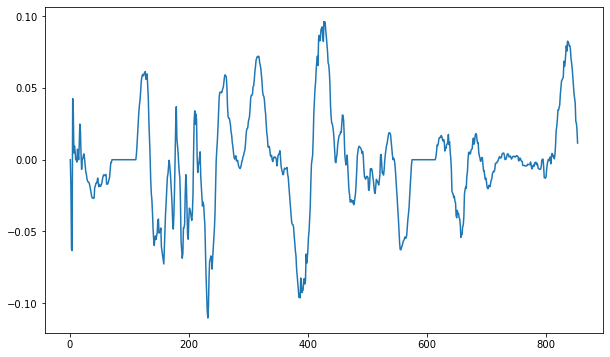

In [13]:
plt.figure(figsize=[10,6])
plt.plot(calcDF['grade'])

In [14]:
calcDF['cumDist'] = calcDF['dist'].cumsum()

In [15]:
calcDF

,lat,lon,ele,lat_prev,lon_prev,ele_prev,dist,eleDiff,grade,angle,cumDist
1,47.57118,-122.37611,91.0,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000
2,47.56649,-122.37620,81.5,47.57118,-122.37611,91.0,521.487223,-9.5,-0.018217,-1.043649,521.487223
3,47.56526,-122.37620,73.0,47.56649,-122.37620,81.5,136.753703,-8.5,-0.062156,-3.556675,658.240926
4,47.56408,-122.37617,64.7,47.56526,-122.37620,73.0,131.214003,-8.3,-0.063255,-3.619448,789.454929
5,47.56409,-122.37748,68.9,47.56408,-122.37617,64.7,98.586174,4.2,0.042602,2.439458,888.041103
...,...,...,...,...,...,...,...,...,...,...,...
849,47.57556,-122.37719,102.1,47.57547,-122.37719,102.2,10.006385,-0.1,0.039650,-0.572573,70453.459867
850,47.57556,-122.37707,100.9,47.57556,-122.37719,102.1,9.028248,-1.2,0.026710,-7.571157,70462.488115
851,47.57132,-122.37712,95.1,47.57556,-122.37707,100.9,471.426772,-5.8,0.025411,-0.704879,70933.914887
852,47.57118,-122.37712,95.1,47.57132,-122.37712,95.1,15.565477,0.0,0.020560,0.000000,70949.480364


# Power

In [16]:
from scipy.interpolate import interp1d

class vehicle:
    '''Class of type vehicle, where A is area, 
    CD is drag coefficient, eta is drivetrain efficiency,
    and m is mass of rider and bike.'''
    
    def __init__(self, CD, A, mass,eta):
        self.CD = CD
        self.A = A
        self.mass = mass
        self.eta = eta
        
def Pd(p,v,A,Cd,eta=.96):
    '''Calculate power to overcome aerodynamic drag.'''
    return .5*p*v**3*A*Cd/eta
def Pr(v,m,Cr,eta=.96):
    '''Calculate power to overcome rolling resistance'''
    return v*m*9.81*Cr/eta
def Pc(v,m,s,eta=.96):
    '''Calculate power to climb a grade(slope).'''
    return v*m*9.81*np.sin(np.arctan(s))/eta
def Pa(v,m,a,eta=.96):
    '''Calculate power to accelerate.'''
    return v*m*a/eta

crr = [.0035,.0039,.005,.0056,.0061,.0063,.0065,.0067,.0069,.0071,.0072]
vs = [0,2,8,12,18,22,27,33,39,46,50]

crr_df = pd.DataFrame(crr, index=vs, columns=['Crr'])
crr_df = crr_df.reindex(np.arange(0,50.01,.01)).interpolate('pchip')
Crr = interp1d(crr_df.index, crr_df['Crr'])

In [17]:
def next_velocity(time_delta, current_velocity, power_in, vehicle, slope, density=1.225):
    # power to roll
    PR = Pr(v=current_velocity, m=vehicle.mass, Cr=Crr(current_velocity), eta=vehicle.eta)
    # power to overcome drag
    PD = Pd(p=density,v=current_velocity,A=vehicle.A, Cd=vehicle.CD, eta=vehicle.eta)
    # power to climb
    PC = Pc(v=current_velocity, m=vehicle.mass, s=slope, eta=vehicle.eta)
    # power to accelerate
    PA = (power_in - PR - PD - PC)*vehicle.eta
    A = PA/(vehicle.mass*current_velocity)
    NV = current_velocity+A*time_delta
    return NV, PA, PD, PR, PC

In [18]:
def step_speeds(ts, power, vehicle, course_df):
    vel=0.1
    dist=0
    velocities = []
    pas = []
    pds = []
    prs = []
    pcs = []
    dists = []
    slopes = []
    totalDist = course_df['dist'].sum()
    slope = course_df.iloc[0]['grade']

    while dist < totalDist:
        n_vel, PA, PD, PR, PC = next_velocity(ts,vel,power,vehicle,slope)
        velocities.append(n_vel)
        pas.append(PA)
        prs.append(PR)
        pds.append(PD)
        pcs.append(PC)
        dists.append(dist)
        slopes.append(slope)
        
        vel=n_vel
        dist = sum(np.array(velocities)*ts)
        print(dist/1000)
        if dist < course_df.iloc[0]['cumDist']:
            slope = course_df.iloc[0]['grade']
        else:
            slope = course_df[course_df['cumDist'] <= dist].iloc[-1]['grade']
        
    df = pd.DataFrame({'pa':pas,
                       'pr':prs,
                       'pd':pds,
                       'pc':pcs,
                       'vel':velocities,
                       'dist':dists,
                       'slope':slopes,
                       'timestep':ts})
    
    df['pt'] = df[['pa','pr','pd','pc']].sum(axis=1)
    df['mph'] = df['vel'] * 2.236936 # convert to mph
    df['hours'] = df['timestep'].cumsum()/60/60
    
    # total energy used
    df['energy'] = (df['pt'] * df['timestep']/60/60).cumsum() # watt hours
        
    return df

In [19]:
touringRider = vehicle(CD=1,A=.4,mass=95,eta=.97)

In [20]:
baseline = step_speeds(ts=.2,power=170, vehicle=touringRider, course_df=calcDF)

0.0007129333487308774
0.0014423852410139699
0.0021878469675826817
0.002948842802641032
0.0037249263422491803
0.00451567739779166
0.005320699340585897
0.00613961681639352
0.006972073766008769
0.007817731700952285
0.008676268193377155
0.009547375547011357
0.010430759622041135
0.011326138791657685
0.012233243011818365
0.013151812988807288
0.01408159943168922
0.015022362378792346
0.01597387058901276
0.01693590098999597
0.01790823817658024
0.018890673953714233
0.019883006918762665
0.020885042078991906
0.021896590500439444
0.022917468984936386
0.023947499772308912
0.024986510265324967
0.026034332775254704
0.02709080428582446
0.028155766234150306
0.029229064306855783
0.030310548250126225
0.03140007169246668
0.03249749197905081
0.03360267001667974
0.03471547012846996
0.03583575991747666
0.036963410138537406
0.03809829457772971
0.039240289938785075
0.040389275735919085
0.04154513419278874
0.04270775014677989
0.0438770109586354
0.04505280642671006
0.04623502870571703
0.04742357222965163
0.048618

1.0921042525479048
1.0929593594360336
1.0938104164826146
1.094657520284751
1.095500765767123
1.0963402461863374
1.0971760531361012
1.098008276553212
1.0988370047243827
1.099662324293863
1.1004843202718442
1.1013030760436655
1.1021186733798454
1.1029311924467766
1.1037407118182392
1.1045473084875985
1.105351057880717
1.1061520338695259
1.1069503087862826
1.1077459534383984
1.1085390371239223
1.1093296276475655
1.1101177913372582
1.1109035930612359
1.1116870962456185
1.1124683628924246
1.1132474535980006
1.114024427571853
1.1147993426558362
1.1155722553436718
1.1163432208007642
1.1171122928842845
1.1178795241634916
1.1186449659402617
1.1194086682697966
1.1201706799814837
1.1209310486998796
1.1216898208658057
1.1224470417574828
1.1232027555117219
1.1239570051451406
1.1247098325753846
1.1254612786423175
1.1262113831291405
1.1269601847834663
1.1277077213383238
1.1284540295330003
1.1291991451338041
1.1299431029546811
1.1306859368776343
1.1314276798730438
1.1321683640197129
1.1329080205247897

1.6050807570693142
1.606352222907008
1.6076267644769493
1.6089043341554217
1.6101848851330423
1.611468371397765
1.6127547477183408
1.6140439696282558
1.615335993410138
1.6166307760805103
1.617928275375127
1.6192284497344933
1.6205312582899054
1.6218366608498744
1.6231446178867912
1.624455090524006
1.6257680405233084
1.627083430272586
1.6284012227738547
1.6297213816315905
1.6310438710413737
1.6323686557787862
1.6336957011885456
1.6350249731739284
1.6363564381864444
1.6376900632157536
1.639025815779817
1.640363663915277
1.6417035761680545
1.6430455215841633
1.6443894697007286
1.645735390537208
1.6470832545868064
1.648433032808079
1.649784696616719
1.651138217877523
1.652493568896528
1.6538507224133188
1.6552096515934953
1.6565703300213006
1.6579327316924037
1.65929683100683
1.6606626027620397
1.6620300221461823
1.6633990647314372
1.6647697064674905
1.6661419236751587
1.6675156930401376
1.6688909916069137
1.6702677967727608
1.6716460862818194
1.6730258382193242
1.6744070310059849
1.675789

2.4253704312659323
2.42694868375138
2.4285269455511265
2.4301052165344093
2.431683496572302
2.4332617855376877
2.4348400833052346
2.4364183897513714
2.43799670475426
2.4395750281937745
2.4411533599514748
2.4427316999105835
2.444310047955963
2.4458884039740925
2.4474667678530446
2.4490451394824637
2.450623518753543
2.4522019055590043
2.453780299793075
2.4553587013514666
2.456937110131356
2.458515526031363
2.4600939489515317
2.461672378793309
2.4632508154595243
2.464829258854373
2.4664077088833944
2.467986165453455
2.469564628472728
2.471143097850676
2.472721573498032
2.474300055326784
2.4758785432501536
2.477457037182582
2.479035537039712
2.480614042738369
2.4821925541965473
2.483771071333393
2.485349594069186
2.486928122325326
2.4885066560243163
2.490085195089748
2.491663739446285
2.493242289019649
2.4948208437366044
2.496399403524943
2.4979779683134717
2.4995565380319964
2.5011351126113075
2.5027136919831685
2.5042922760803004
2.5058708648363672
2.5074494581859668
2.5090280560646128
2

3.140399665451514
3.1418865339502178
3.1433734878714867
3.144860525995306
3.1463476471191085
3.1478348500575244
3.1493221336421353
3.150809496721231
3.15229693815957
3.153784456838143
3.15527205165394
3.1567597215197214
3.158247465363793
3.1597395188287245
3.161235820407062
3.16273630952905
3.1642409265454137
3.1657496127106333
3.167262310166657
3.168778961927024
3.170299511861393
3.171823904680451
3.1733520859211968
3.174884001932577
3.176419599861483
3.177958827639092
3.179501633967468
3.181047968306497
3.182597780861131
3.1841510225689436
3.185707645087972
3.1872676007847263
3.1888280319246514
3.1903889318148013
3.1919502938569315
3.193512111546139
3.195074378469525
3.196637088304931
3.198200234819624
3.1997638118689884
3.201327813395263
3.2028922334263057
3.2044570660744465
3.206022305535206
3.2075879460861056
3.209153982085502
3.2107204079714387
3.212287218260573
3.2138544075469864
3.215421970501083
3.2169899018685038
3.2185581964690537
3.2201268491957036
3.2216958550135044
3.2232

3.9719022682653558
3.974082833793883
3.976264549942401
3.978447400091232
3.9806313678579186
3.982816437093668
3.985002591880463
3.9871898165274504
3.989378095568108
3.99156741375683
3.993757756066067
3.995949107683094
3.9981414540071603
4.000334780646377
4.002529073414939
4.004724318330076
4.006920501609384
4.009117609667804
4.011315629115107
4.013514546752834
4.015714349572001
4.017915024750033
4.020116559648458
4.022318941810101
4.024522158956617
4.026726198986015
4.028931049969978
4.031136700151763
4.033343137943417
4.035550351923607
4.037758330835229
4.0399670635829175
4.0421765392311215
4.044386747001501
4.046597676270798
4.0488093165687875
4.0510216575758715
4.0532346891211075
4.055448401180108
4.057662783872798
4.059877827461555
4.0620935223491355
4.0643098590765545
4.066526828321282
4.068744420895289
4.070962627742993
4.073181439939474
4.075400848688717
4.077620845321577
4.0798414212939775
4.0820625681854175
4.084284277696921
4.086507505791543
4.0887322303890965
4.090958429725


5.40658089426078
5.408653062469918
5.410725194801351
5.4127972917652
5.414869353864329
5.416941381594454
5.419013375444237
5.421085335895392
5.423157263422792
5.425229158494554
5.427301021572141
5.42937285311045
5.431444653557906
5.433516423356561
5.435588162942176
5.437659872744318
5.439731553186441
5.441803204685979
5.4438748276544295
5.445946422497436
5.4480179896148755
5.450089529400936
5.4521610422442
5.454232528527725
5.456303988629119
5.458375422920622
5.460446831769181
5.462518215536521
5.464589574579227
5.4666609092488105
5.468732219891786
5.470803506849738
5.472874770459398
5.474946011052705
5.4770172289568775
5.479088424494484
5.4811595979835035
5.4832307497373955
5.485301880065162
5.4873729892714085
5.489444077656411
5.491515145516176
5.493586193142501
5.495657220823032
5.49772822884133
5.499799217476917
5.501870187005347
5.50394113769825
5.5060120698234005
5.5080829836447585
5.5101538794225355
5.51222475741324
5.514295617869738
5.516366461041296
5.518437287173636
5.5205080

6.578940396105956
6.581021177746509
6.583101685346982
6.585181922808177
6.587261893975217
6.589340600076246
6.591418059115761
6.593494288838975
6.595569306735695
6.597643130044193
6.599715775754719
6.601787260613365
6.60385760112549
6.605926813559308
6.607994913949431
6.6100619181001425
6.612127841589012
6.614192699769939
6.616256507776713
6.618319280525972
6.620381032720599
6.6224417788526555
6.624501533206638
6.626560309862341
6.628618122698004
6.630674985393088
6.632730911431354
6.634785914103499
6.63684000651022
6.63889320156471
6.640945511995647
6.64299695034965
6.645047528994076
6.64709726011955
6.64914615574252
6.651194227707878
6.653241487691276
6.655287947201816
6.657333617584249
6.659378510021444
6.661422635536769
6.663466004996265
6.665508629111113
6.667550518439727
6.669591683389947
6.671632134221385
6.67367188104737
6.67571093383714
6.677749302417984
6.679786996477154
6.681824025563979
6.683860399091872
6.685896126340178
6.687931216456191
6.689964957129139
6.69199736745493

7.663184335575095
7.665239761672912
7.667294996193108
7.669350041853729
7.671404901334192
7.673459577275831
7.675514072282441
7.677568388920811
7.679622529721258
7.681676497178139
7.683730293750384
7.685783921862023
7.687837383902651
7.689890682227909
7.691943819159972
7.693996796988027
7.696049617968741
7.698102284326725
7.700154798254992
7.702207161915403
7.704258760093484
7.706309603645054
7.708359703270975
7.710409069519292
7.7124577127876375
7.714505643325247
7.716552871235097
7.718599406476192
7.720645258865453
7.722690438079815
7.72473495365837
7.726778815004188
7.728822031386329
7.730864611941891
7.732906565677755
7.734947901472472
7.7369886280782865
7.73902875412277
7.74106828811062
7.743107238425576
7.745145613332053
7.747183420976815
7.749220669390737
7.751257366490519
7.7532935200802156
7.755329137852857
7.757364227392157
7.7593987961740165
7.761432851568024
7.763466400838982
7.765499451148545
7.767532009556586
7.7695640830226305
7.771595678407304
7.773626802473868
7.775657

8.599307841159154
8.60091959011719
8.602531289553147
8.604142940159393
8.60575454261863
8.607366097604006
8.608977605779272
8.610589067798891
8.61220048430819
8.613811855943467
8.615423183332133
8.617034467092829
8.618645707835544
8.620256906161746
8.621868062664499
8.623479177928568
8.625090252530551
8.62670128703899
8.628312282014472
8.629923238009749
8.631534155569852
8.633145035232191
8.634755877526665
8.63636668297576
8.637977452094667
8.63958818539137
8.641198883366753
8.6428095465147
8.644420175322187
8.64603077026939
8.647641331829764
8.649251860470152
8.650862356650865
8.652472820825786
8.654083253442446
8.655693654942127
8.657304025759933
8.658914366324895
8.660524677060039
8.66213495838248
8.663745210703503
8.665355434428639
8.666965629957755
8.668575797685122
8.670185937999504
8.671796051284229
8.673406137917263
8.67501619827129
8.676626232713783
8.678236241607078
8.679846225308442
8.68145618417015
8.683066118539552
8.684676028759133
8.6862859151666
8.687895778094932
8.6895

9.384366082643346
9.385974293830719
9.387582504966822
9.389190716052374
9.39079892708808
9.392407138074637
9.394015349012735
9.395623559903047
9.397231770746247
9.39883998154299
9.400448192293927
9.4020564029997
9.403664613660936
9.405272824278263
9.406881034852294
9.408489245383631
9.410097455872876
9.411705666320614
9.413313876727429
9.41492208709389
9.416530297420563
9.418138507708004
9.419746717956762
9.42135492816738
9.42296313834039
9.424571348476315
9.426179558575678
9.427787768638987
9.429395978666749
9.431004188659461
9.432612398617612
9.434220608541684
9.435828818432155
9.437437028289496
9.43904523811417
9.440653447906632
9.442261657667336
9.443869867396723
9.445478077095233
9.447086286763296
9.44869449640134
9.450302706009783
9.45191091558904
9.453519125139518
9.455127334661622
9.456735544155746
9.458343753622282
9.459951963061618
9.461560172474131
9.4631683818602
9.464776591220192
9.466384800554474
9.4679930098634
9.469601219147332
9.471209428406617
9.472817637641597
9.4744

10.33160057492665
10.333208782449217
10.334816989971772
10.336425197494314
10.338033405016844
10.33964161253936
10.341249820061867
10.34285802758436
10.344466235106841
10.34607444262931
10.34768265015177
10.349290857674218
10.350899065196653
10.35250727271908
10.354115480241495
10.355723687763899
10.357331895286292
10.358940102808674
10.360548310331048
10.362156517853409
10.363764725375763
10.365372932898104
10.366981140420437
10.36858934794276
10.370197555465076
10.371805762987382
10.373413970509679
10.375022178031966
10.376630385554245
10.378238593076514
10.379846800598774
10.381455008121026
10.383063215643272
10.384671423165505
10.386279630687733
10.387887838209954
10.389496045732164
10.391104253254369
10.392712460776565
10.394320668298754
10.395928875820934
10.397537083343106
10.399145290865272
10.40075349838743
10.40236170590958
10.403969913431727
10.405578120953866
10.407186328475996
10.40879453599812
10.410402743520239
10.41201095104235
10.413619158564456
10.415227366086555
10.4

11.2354132021609
11.237021409682553
11.238629617204206
11.240237824725858
11.241846032247512
11.243454239769164
11.245062447290817
11.246670654812469
11.248278862334121
11.249887069855776
11.251495277377428
11.25310348489908
11.254711692420733
11.256319899942385
11.25792810746404
11.259536314985692
11.261144522507344
11.262752730028996
11.264360937550649
11.265969145072303
11.267577352593955
11.269185560115607
11.27079376763726
11.272401975158912
11.274010182680566
11.275618390202219
11.277226597723871
11.278834805245523
11.280443012767178
11.28205122028883
11.283659427810482
11.285267635332135
11.286875842853787
11.288484050375441
11.290092257897093
11.291700465418746
11.293308672940398
11.29491688046205
11.296525087983705
11.298133295505357
11.29974150302701
11.301349710548662
11.302957918070314
11.304566125591968
11.30617433311362
11.307782540635273
11.309390748156925
11.310998955678578
11.312607163200232
11.314215370721884
11.315823578243537
11.317431785765189
11.319039993286843
11

12.082366861219086
12.083891886521153
12.085416695951578
12.08694129256831
12.088465679386108
12.089989859377134
12.091513835471568
12.093037610558193
12.094561187484999
12.096084569059736
12.097607758050474
12.099130757186158
12.100653569157167
12.102176196615844
12.103698642177042
12.105220908418646
12.1067429978821
12.108264913072906
12.109786656461157
12.111305700587947
12.11282208372417
12.114335843618424
12.115847017503896
12.117355642105121
12.11886175364457
12.12036538784921
12.12186657995706
12.12336536472353
12.124861776427698
12.12635584887856
12.127847615421153
12.129334105205004
12.130815393554263
12.132291554810068
12.133762662342967
12.135228788565245
12.13669000494281
12.138146382007138
12.13959798936677
12.141044895718775
12.142487168859974
12.143924875697936
12.14535808226189
12.146786853713417
12.148208518871321
12.149623180952364
12.15103094190086
12.152431902404135
12.153826161907746
12.155213818630148
12.156594969577196
12.157969710556173
12.159338136189515
12.160

12.49899129107385
12.49965211719462
12.500312919160447
12.50097369783087
12.501634454034892
12.502295188572063
12.502955902213518
12.503616595702992
12.50427726975778
12.504937925069685
12.505598562305916
12.506259182109963
12.506919785102433
12.507580371881865
12.508240943025514
12.508901499090104
12.50956204061256
12.510222568110704
12.510883082083943
12.51154358301391
12.51220407136511
12.512864547585513
12.513525012107158
12.514185465346698
12.51484590770597
12.515506339572505
12.516166761320038
12.516827173309007
12.517487575887017
12.5181479693893
12.518808354139153
12.519468730448368
12.520129098617632
12.520789458936928
12.521449811685914
12.52211015713429
12.522770495542154
12.523430827160341
12.524091152230756
12.524751470986685
12.525411783653107
12.526072090446995
12.526732391577585
12.527392687246667
12.528052977648844
12.528713262971783
12.529373543396472
12.530033819097447
12.530694090243031
12.531354356995548
12.532014619511541
12.532674877941977
12.533335132432445
12.5

12.780454266590361
12.781014590133578
12.781574913651792
12.78213523714619
12.7826955606179
12.783255884068003
12.783816207497525
12.784376530907442
12.784936854298687
12.785497177672145
12.786057501028663
12.786617824369044
12.787178147694055
12.787738471004426
12.788298794300852
12.788859117583996
12.789419440854488
12.78997976411293
12.790540087359892
12.791100410595922
12.791660733821539
12.792221057037235
12.792781380243483
12.793341703440731
12.79390202662941
12.794462349809923
12.795022672982657
12.795582996147985
12.796143319306257
12.796703642457807
12.797263965602957
12.797824288742008
12.798384611875253
12.798944935002966
12.799505258125409
12.800065581242833
12.800625904355478
12.80118622746357
12.801746550567323
12.802306873666945
12.802867196762632
12.803427519854573
12.803987842942943
12.804548166027912
12.805108489109642
12.805668812188287
12.806229135263994
12.8067894583369
12.807349781407142
12.807910104474844
12.808470427540128
12.809030750603107
12.80959107366389
12

13.044201661311243
13.044747757471757
13.045293853632257
13.045839949792743
13.046386045953216
13.046932142113677
13.047478238274126
13.048024334434562
13.048570430594987
13.049116526755402
13.049662622915807
13.050208719076204
13.050754815236592
13.051300911396972
13.051847007557342
13.052393103717707
13.052939199878063
13.053485296038412
13.054031392198754
13.054577488359092
13.055123584519423
13.055669680679749
13.056215776840068
13.056761873000383
13.057307969160693
13.057854065321
13.058400161481298
13.058946257641596
13.059492353801888
13.060038449962178
13.060584546122463
13.061130642282746
13.061676738443024
13.0622228346033
13.062768930763573
13.063315026923846
13.063861123084113
13.064407219244378
13.06495331540464
13.0654994115649
13.066045507725159
13.066591603885415
13.06713770004567
13.067683796205923
13.068229892366174
13.068775988526424
13.069322084686672
13.069868180846917
13.070414277007163
13.070960373167408
13.071506469327648
13.072052565487889
13.07259866164813
13.

13.291009505585523
13.291553130274902
13.292096685955695
13.29264017609044
13.293183603968684
13.293726972715547
13.294270285299879
13.294813544542018
13.295356753121157
13.295899913582367
13.296443408922862
13.296987222325159
13.297531337833773
13.298075740309317
13.298620415385223
13.299165349426897
13.299710529493176
13.300255943299947
13.300801579185762
13.301347426079376
13.301893473469052
13.302439711373546
13.302986130314673
13.303532721291349
13.304079475755033
13.304626385586493
13.305173443073794
13.305720640891488
13.306267972080873
13.306815430031312
13.307363008462543
13.307910701407893
13.308458503198386
13.309006408447685
13.309554412037796
13.310102509105535
13.310650695029679
13.31119896541879
13.311747316099654
13.312295743106334
13.312844242669758
13.313392811207857
13.313941445316203
13.314490141759121
13.31503889746126
13.31558709438107
13.31613476010401
13.31668192090103
13.317228601786702
13.317774826575194
13.318320617934148
13.318865997436506
13.319410985610302

13.542441487550061
13.542972965755016
13.543504443959971
13.544035922164927
13.544567400369882
13.545098878574835
13.545630356779789
13.546161834984742
13.546693313189696
13.547224791394651
13.547756269599605
13.548287747804558
13.548819226009511
13.549350704214465
13.549882182419418
13.550413660624372
13.550945138829325
13.551476617034279
13.552008095239232
13.552539573444186
13.55307105164914
13.553602529854093
13.554134008059048
13.554665486264001
13.555196964468953
13.555728442673905
13.556259920878857
13.556791399083808
13.55732287728876
13.557854355493712
13.558385833698663
13.558917311903615
13.559448790108567
13.559980268313518
13.56051174651847
13.561043224723422
13.561574702928374
13.562106181133325
13.562637659338277
13.563169137543229
13.56370061574818
13.564232093953132
13.564763572158084
13.565295050363037
13.565826528567989
13.56635800677294
13.566889484977892
13.567420963182844
13.56795220585624
13.568483225316534
13.569014033247132
13.569544640728205
13.570075058266983

13.788510318612502
13.789073795240098
13.789637252873465
13.790200692405726
13.79076411468806
13.791327520531665
13.79189091070963
13.792454285958733
13.793017646981125
13.793580994445971
13.794144328990983
13.794707651223911
13.795270961723933
13.795834261043003
13.79639754970713
13.796960828217596
13.797524097052111
13.79808735666593
13.798650607492897
13.799213849946455
13.799777084420604
13.800340311290817
13.800902375730885
13.801463332542836
13.80202323413525
13.80258213061058
13.803140069850887
13.803697097601772
13.80425325755448
13.804808591426031
13.805363139037366
13.805916938389382
13.806470025736884
13.807022435660379
13.807574201135695
13.808125353601431
13.808675923024232
13.809225937961873
13.809775425624213
13.810324411931994
13.810872921573532
13.811420978059333
13.811968603774673
13.812515820030159
13.813062647110353
13.81360910432046
13.814155210031156
13.81470098172161
13.815246436020734
13.815791588746707
13.816336454944858
13.816881048923914
13.817425384290718
13

14.487533174245739
14.49040711581472
14.493282087031785
14.496158070724116
14.499035050001197
14.501913008250462
14.504791929132683
14.507671796577764
14.510552594780275
14.513434308195347
14.516316921534367
14.519200419760958
14.522084788086872
14.52496887327791
14.52785268006711
14.530736213108101
14.53361947697644
14.536502476170913
14.539385215114834
14.542267698157318
14.545149929574537
14.548031913570952
14.550918794575297
14.55381049072235
14.55670692142371
14.559608007350976
14.562513670418943
14.565423833768925
14.568338421752275
14.571257359914016
14.574180574976555
14.577107994823566
14.580039548484015
14.582975166116343
14.585914778992754
14.588858319483672
14.591805721042334
14.594756918189518
14.597711846498427
14.600670442579714
14.603637277073862
14.606612209698538
14.609595102294515
14.612585818802465
14.6155842252397
14.618590189676894
14.621603582214755
14.624624274960796
14.627652142005923
14.630687059401144
14.63372890513436
14.636777559107008
14.63983290311095
14.

15.866254578242694
15.868871303518112
15.87148776079028
15.874105344209015
15.87672403607162
15.879343818949334
15.881964675683175
15.884586589379992
15.887209543408352
15.88983352139474
15.892458507219537
15.895084485013356
15.897711439153099
15.900339354258417
15.90296821518787
15.905598007035492
15.908228715127057
15.910860325016724
15.913492822483459
15.916126193527695
15.918760424367957
15.921395501437505
15.924031411381163
15.926668141051978
15.929305677508184
15.93194400800997
15.934583120016434
15.937223001182584
15.939863639356261
15.942505022575302
15.94514713906455
15.947789977232999
15.950433525671047
15.953077773147625
15.955722708607492
15.958368321168589
15.961014600119285
15.963661534915818
15.966309115179738
15.968957330695288
15.971606171406945
15.974256468543679
15.976908199042763
15.979561340199279
15.982215869660815
15.984869886912964
15.98752340007523
15.990176417137551
15.992828945962318
15.99548099428643
15.998132569723333
16.000778715324916
16.003419517059672
1

16.880250986926203
16.88301149972721
16.885755463850774
16.888483147565342
16.89119481379449
16.893890720257946
16.896571119607877
16.89923625956063
16.901886383024
16.904521728220224
16.90714252880511
16.909749013983035
16.912341408618314
16.91491993334298
16.91748480466106
16.920036235049558
16.92257443305618
16.925099603394024
16.9276119470334
16.930111661290585
16.932598939914033
16.935073973167896
16.937536947912914
16.939988047684974
16.942427452771227
16.944855340283993
16.94727188423242
16.949677255592146
16.95207162237275
16.954455149687124
16.95682799983526
16.95919033236732
16.96154230414147
16.963884069380352
16.966215779726102
16.96853758429356
16.970849629722274
16.973152060227108
16.97544501764767
16.97772864149612
16.98000306900388
16.982268435167303
16.984524872792004
16.98677251253604
16.989011482952083
16.991241910528572
16.993463919729596
16.995677633033978
16.99788317097356
17.000080652170155
17.002270193371803
17.004451909488118
17.006625913624802
17.0087923171172

17.44491421958446
17.445570988174662
17.446227745361192
17.446884491554094
17.44754122714868
17.448197952526055
17.448854668053627
17.44951137408561
17.450168070963485
17.450824759016456
17.4514814385619
17.452138109905782
17.452794773343076
17.45345142915815
17.454108077625147
17.454764719008363
17.45542135356258
17.45607798153344
17.456734603157727
17.457391218663737
17.45804777504917
17.458704274440795
17.45936071888919
17.460017110371442
17.460673450793756
17.46132974199398
17.461985985744043
17.4626421837523
17.4632983376658
17.46395444907247
17.46461051950322
17.465266550433988
17.4659225432877
17.46657849943615
17.467234420201848
17.46789030685977
17.46854616063906
17.469201982724673
17.46985777425895
17.47051353634315
17.471169270038914
17.471824976369692
17.472480656322105
17.473136310847277
17.473791940862085
17.474447547250413
17.475103130864323
17.475758692525186
17.476414233024812
17.477069753126482
17.477725253565993
17.47838073505263
17.47903619827014
17.479691643877615


17.749302131965038
17.749885646534505
17.75046915358383
17.75105265344518
17.751636146436063
17.75221963285997
17.75280311300698
17.753386587154377
17.753970055567198
17.75455351849877
17.75513697619124
17.755720428876057
17.756303876774446
17.756887320097874
17.757470759048456
17.758054193819383
17.758637624595316
17.759221051552768
17.759804474860434
17.760387894679575
17.760971311164322
17.761554724462002
17.76213813471343
17.7627215420532
17.76330494660997
17.763888348506693
17.764471747860917
17.765055144784977
17.765638539386252
17.766221931767376
17.766805322026457
17.76738871025725
17.76797209654939
17.768555480988535
17.76913886365657
17.769722244631748
17.77030562398888
17.770889001799464
17.771472378131836
17.77205575305132
17.772639126620348
17.773222498898594
17.773805869943104
17.77438923980839
17.77497260854656
17.77555597620742
17.77613934283859
17.776722708485554
17.777306073191816
17.777889436998944
17.778472799946666
17.779056162072965
17.77963952341414
17.7802228840

18.033343515100384
18.03389729921619
18.034451083331998
18.035004867447807
18.035558651563612
18.03611243567942
18.03666621979523
18.037220003911035
18.037773788026843
18.038327572142652
18.038881356258457
18.039435140374266
18.039988924490075
18.04054270860588
18.04109649272169
18.041650276837494
18.042204060953303
18.04275784506911
18.043311629184917
18.043865413300725
18.044419197416534
18.04497298153234
18.045526765648148
18.046080549763957
18.046634333879762
18.04718811799557
18.04774190211138
18.048295686227185
18.04884947034299
18.049403254458795
18.049957038574597
18.050510822690402
18.051064606806204
18.05161839092201
18.052172175037814
18.052725959153616
18.05327974326942
18.053833527385226
18.054387311501028
18.054941095616833
18.055494879732635
18.05604866384844
18.056602447964245
18.057156232080047
18.057710016195852
18.058263800311657
18.05881758442746
18.059371368543264
18.059925152659066
18.06047893677487
18.061032720890676
18.061586505006478
18.062140289122283
18.06269

18.315746331503508
18.31629408648986
18.316841926742917
18.317389848043845
18.317937846383657
18.31848591795267
18.31903405913049
18.319582266476534
18.320130536720995
18.320678866756335
18.32122725362913
18.32177569453238
18.322324186798223
18.322872727890946
18.323421315400438
18.323969947035906
18.32451862061993
18.325067334082842
18.32561608545736
18.32616487287347
18.326713694553632
18.327262548808164
18.327811434030885
18.32836034869497
18.32890929134902
18.329458260613315
18.330007255176263
18.33055627379103
18.331105315272325
18.33165437849336
18.332203462382942
18.332752565922743
18.33330168814466
18.33385082812835
18.33439998499886
18.33494915792439
18.33549834611415
18.336047548816335
18.336596765316212
18.337145994934275
18.337695237024516
18.33824449097276
18.338793756195102
18.33934303213641
18.339892318268905
18.340441614090818
18.34099091912509
18.341540232918177
18.342089555038864
18.342638885077182
18.343188222643363
18.343737567366823
18.344286918895236
18.3448362768

18.59025605945307
18.59081285240727
18.591369645650907
18.591926439170066
18.59248323295152
18.59304002698266
18.593596821251495
18.594153615746606
18.59471041045712
18.595267205372696
18.59582400048348
18.59638079578008
18.596937591253585
18.597494386895495
18.598051182697716
18.59860797865255
18.59916477475266
18.59972157099107
18.60027836736113
18.600835163856527
18.601391960471233
18.601948757199516
18.602505554035922
18.60306235097525
18.603619148012566
18.604175945143158
18.604732742362543
18.605289539666458
18.60584633705084
18.606403134511822
18.60695993204573
18.607516729649056
18.60807352731846
18.608630325050783
18.609187122842986
18.6097439206922
18.610300718595685
18.610857516550837
18.611414314555173
18.611971112606323
18.612527910702045
18.613084708840198
18.61364150701874
18.614198305235732
18.61475510348933
18.615311901777773
18.615868700099384
18.61642549845257
18.616982296835822
18.617539095247686
18.61809589368679
18.61865269215183
18.61920949064156
18.6197662891547

18.86977528332313
18.87039246825048
18.871009698320147
18.87162697172588
18.872244286733913
18.872861641680046
18.873479034966838
18.8740964650609
18.874713930490344
18.875331429842266
18.875948961760404
18.876566524942834
18.8771841181398
18.877801740151604
18.878419389826593
18.879037066059237
18.879654767788267
18.880272493994894
18.880890243701106
18.881508015968038
18.882125809894386
18.882743624614918
18.883361459299007
18.883979313149247
18.884597185400136
18.88521507531678
18.885832982193673
18.886450905353506
18.88706884414607
18.887686797947133
18.888304766157418
18.888922748201605
18.88954074352736
18.890158751604424
18.890776771923733
18.89139480399656
18.892012847353698
18.892630901544692
18.893248966137087
18.89386704071569
18.894485124881903
18.89510321825305
18.89572132046172
18.896339431155205
18.896957549994855
18.897575676655563
18.898193810825195
18.898811952204085
18.899430100504524
18.900048255450297
18.900666416776218
18.901284584227685
18.901902757560254
18.9025

19.152552808671214
19.153371033646888
19.154191076888328
19.15501289240725
19.155836435522463
19.156661662815033
19.1574885320854
19.158317002312316
19.159147033613603
19.1599785872085
19.16081162538161
19.161646111448334
19.162482009721675
19.16331928548039
19.164157904938456
19.16499783521566
19.16583904430937
19.166681501067423
19.167525175161966
19.168370037064363
19.169216058021
19.170063210029948
19.170911465818595
19.171760798821932
19.172611183161756
19.173462991438942
19.17431618957732
19.175170744394066
19.17602662357235
19.17688379563506
19.177742229919527
19.178601896553126
19.179462766429832
19.180324811187617
19.181188003186623
19.182052315488203
19.182917721834567
19.183784196629286
19.18465171491836
19.185520252372005
19.186389785267032
19.187260290469826
19.188131745419906
19.189004128114007
19.18987741709072
19.190751591415612
19.191626630666818
19.19250251492115
19.19337922474055
19.194256741159126
19.195135045670416
19.196014120215185
19.19689394716956
19.1977745093

19.58829278093561
19.58938955680391
19.59048649922889
19.591583605285955
19.59268087210226
19.593778296855827
19.594875876774612
19.595973609135605
19.597071491263968
19.59816952053214
19.59926769435901
19.600366010209104
19.60146446559173
19.602563058060184
19.603662707912793
19.60476339662062
19.605865105996607
19.60696781818861
19.608071515672655
19.609176181246248
19.61028179802197
19.611388349421127
19.612495819167595
19.613604191281798
19.614713450074795
19.61582358014259
19.61693456636041
19.618046393877346
19.619159048110863
19.62027251474164
19.621386779708384
19.622501829202836
19.623617649664883
19.624734227777715
19.62585155046319
19.626969604877218
19.628088378405234
19.629207858657903
19.63032803346673
19.631448890879877
19.632570419158107
19.633692606770666
19.6348154423914
19.635938914894894
19.637063013352673
19.638187727029486
19.639313045379765
19.64043895804399
19.64156545484523
19.64269252578582
19.643820161043937
19.644948350970367
19.646077086085327
19.6472063570

20.213099023885842
20.214653617364572
20.216207889495507
20.217761844806592
20.219315487762195
20.22086882276406
20.2224218541521
20.22397458620529
20.225527023142497
20.227079169123325
20.228631028248937
20.23018260456291
20.23173390205203
20.233284924647062
20.234835676223522
20.236386160602468
20.23793638155124
20.23948634278423
20.241036047963608
20.24258550070011
20.244134704553694
20.245683663034264
20.247232379602362
20.24878085766987
20.25032910060067
20.251877111711334
20.25342489427178
20.25497245150597
20.256519786592502
20.258066902665256
20.259615200789426
20.26116466429038
20.262715276732035
20.264267021913298
20.265819883864594
20.2673738468445
20.26892889533628
20.270485014044738
20.27204218789278
20.27360040201838
20.275159641771285
20.27671989271002
20.27828114059873
20.279843371404287
20.281406571293214
20.28297072662887
20.284535823968483
20.286101850060433
20.28766879184134
20.289236636433486
20.29080537114194
20.292374983452056
20.29394546102676
20.295516791704014

21.071399989522057
21.073105279580595
21.074809770500778
21.07651347338792
21.078216399193284
21.0799185587162
21.08161996260622
21.083320621365115
21.085020545348986
21.086719744770267
21.088418229699688
21.090116010068265
21.09181309566923
21.093509496159925
21.095205221063704
21.096900279771777
21.098594681545038
21.100288435515875
21.10198155068995
21.103674035947943
21.105365900047307
21.10705715162395
21.108747799193917
21.110437851155076
21.112127315788733
21.11381620126125
21.115504515625634
21.11719226682312
21.118879462684706
21.120566110932675
21.122252219182126
21.123937794942435
21.12562284561872
21.12730737851329
21.128991400827083
21.130674919661054
21.132357942017553
21.1340404748017
21.13572252482274
21.13740409879538
21.139085203341043
21.140765844989232
21.14244603017876
21.144125765259023
21.14580505649123
21.147483910049623
21.149162332022684
21.150840328414347
21.152517905145142
21.154195068053347
21.155871822896145
21.157548175350737
21.15922413101547
21.16089969

21.835618341137337
21.837185499226802
21.838752462150453
21.84031923265276
21.841885813439674
21.843452207179173
21.845018416501773
21.846584444001085
21.848150292234294
21.849715963722737
21.851281460952343
21.85284678637415
21.85441194240477
21.8559769314269
21.857541755789768
21.859106417809617
21.860670919770165
21.86223526392305
21.86379945248831
21.86536348765477
21.86692737158054
21.868491106393424
21.87005469419135
21.87161813704277
21.87318143698708
21.874744596035022
21.876307616169104
21.877870499343956
21.879433247486762
21.880995862497624
21.882558346249937
21.88412070059078
21.88568292734127
21.88724502829694
21.888807005228074
21.89036885988009
21.891930593973896
21.893492209206205
21.895053707249883
21.896615089754285
21.898176358345573
21.89973751462706
21.901298560179516
21.902859496561483
21.904420325309598
21.90598104793889
21.907541665943093
21.909102180794925
21.910662593946412
21.91222290682916
21.91378312085464
21.915343237414472
21.916903257880715
21.9184631836

22.522365135503737
22.52348274521614
22.524599225638013
22.52571459624837
22.526828876208693
22.52794208436751
22.52905423926499
22.53016535913738
22.53127546192152
22.532384565259175
22.533492686501464
22.534599842713085
22.535706050676637
22.53681132689676
22.537915687604364
22.53901914876066
22.54012172606127
22.54122343494023
22.542324290573923
22.543424307885065
22.544523501546458
22.545621885984946
22.54671947538509
22.54781628369292
22.548912324619653
22.550007611645245
22.551102158022076
22.55219597677843
22.553289080721992
22.554381482443336
22.55547319431929
22.55656422851632
22.55765459699386
22.558744311507542
22.559833383612474
22.560921824666398
22.56200964583284
22.563096858084197
22.564183472204846
22.565269498794088
22.566354948269158
22.567439830868192
22.56852415665307
22.56960793551226
22.570691177163685
22.57177389115746
22.572856086878627
22.57393777354983
22.57501896023402
22.576099655837034
22.577179869110186
22.578259608652782
22.579338882914662
22.580417700198

22.92004352019472
22.920526275702066
22.921008475304287
22.92149015375638
22.921971343708538
22.92245207582541
22.922932378899624
22.923412279959646
22.923891804372232
22.92437097593962
22.924849816991603
22.925328348472764
22.925806590024997
22.9262845600655
22.92676227586053
22.927239753594968
22.92771700843803
22.928194054605186
22.928670905416546
22.929147573351866
22.929624070102363
22.930100406619438
22.930576593160563
22.931052639332442
22.931528554131546
22.932004345982254
22.93248002277267
22.932955591888287
22.933431060243556
22.933906434311577
22.934381720151922
22.93485644647096
22.935330649286467
22.935804362369797
22.936277617377034
22.936750443973622
22.937222869952617
22.937694921346775
22.93816662253469
22.93863799634122
22.939109064132374
22.939579845904944
22.940050360371067
22.940520625037994
22.940990656283212
22.94146046942523
22.94193007879019
22.942399497774495
22.942868738903744
22.943337813888057
22.943806733674098
22.944275508493867
22.944744147910534
22.9452

23.16487680071695
23.165386156042565
23.165895690997555
23.166405395431028
23.16691525977177
23.167425274994482
23.167935432588063
23.16844572452577
23.168956143237207
23.16946668158193
23.16997733282469
23.170488090612093
23.17099894895067
23.171509902186216
23.172020944984357
23.172532072312258
23.173043279421382
23.173554561831278
23.1740659153143
23.174577335881214
23.175088819767623
23.175600363421218
23.17611196348971
23.17662361680951
23.177135320395024
23.17764888851794
23.178164217019848
23.178681208198807
23.179199770338354
23.179719817278787
23.18024126802608
23.180764046394312
23.181288080678122
23.181813303352012
23.182339650793946
23.182867063030645
23.183395483502693
23.18392485884745
23.184455138698205
23.18498627549804
23.185518224327186
23.186050942742593
23.186584390628802
23.18711853005904
23.187653325165794
23.188188742020085
23.188724748518695
23.189261314278816
23.18979841053947
23.19033601006925
23.19087408707986
23.191412617145083
23.191951577124776
23.19249094

23.504897860161623
23.50569838872917
23.506498918885722
23.507299450589695
23.508099983800598
23.50890051847899
23.509701054586465
23.510501592085628
23.511302130940056
23.512102671114288
23.51290321257378
23.5137037552849
23.51450429921489
23.515304844331858
23.51610539060474
23.51690593800328
23.517706486498028
23.518507036060296
23.519307586662144
23.52010813827637
23.52090869087648
23.521709244436675
23.522509798931832
23.523310354337482
23.524110910629798
23.524911467785582
23.525712025782234
23.52651258459775
23.5273131442107
23.52811370460022
23.528914265745982
23.5297148276282
23.530515390227606
23.53131595352543
23.53211651750339
23.532917082143694
23.533717647429008
23.534518213342448
23.535318779867588
23.53611934698841
23.536919914689328
23.53772048295517
23.538521051771145
23.53932162112286
23.540122190996293
23.540922761377793
23.54172333225406
23.54252390361216
23.543324475439476
23.54412504772373
23.544925620452965
23.545726193615533
23.546526767200103
23.54732734119562

23.98539652017763
23.98658200574507
23.987767684752487
23.988953554037362
23.99013961048929
23.991325851049133
23.992512272708147
23.993698872507153
23.99488564753569
23.99607259493119
23.997259711878204
23.9984469956076
23.999634443395795
24.000822052563986
24.00200982047742
24.003197744544636
24.00438582221677
24.00557405098684
24.00676242838906
24.00795095199812
24.009139619428545
24.010328428334013
24.011517376406715
24.012706461376702
24.013895681011274
24.01508503311434
24.01627451552583
24.017464126121105
24.01865386281033
24.01984372353794
24.021033706282047
24.0222238090539
24.023414029897335
24.02460436688823
24.02579481813397
24.02698538177293
24.028176055973965
24.029366838935903
24.030557728887047
24.031748724084693
24.032939822814647
24.034131023390756
24.03532232415445
24.03651372347428
24.037705219745476
24.0388968113895
24.040088496853624
24.041280274610497
24.04247214315773
24.043664101017487
24.04485614673607
24.046048278883543
24.047240496053327
24.04843279686182
24

24.690016163467458
24.691552093314414
24.693088142211764
24.69462430847662
24.69616059044993
24.697696986496123
24.69923349500278
24.700770114380312
24.702306843061628
24.703843679501812
24.705380622177817
24.70691766958815
24.708454820252566
24.709992072711767
24.711529425527107
24.713066877280298
24.714604426573118
24.716142072027132
24.717679812283404
24.71921764600223
24.720755571862856
24.72229358856322
24.723831694819665
24.725369889366732
24.726908170956843
24.728446538360075
24.729984990363906
24.731523525772957
24.733062143408763
24.734600842109522
24.736139620729865
24.737678478140623
24.739217413228598
24.740756424896333
24.742295512061887
24.743834673658622
24.745373908634985
24.746913215954294
24.74845259459452
24.749992043548094
24.75153156182168
24.753071148435996
24.75461080242561
24.756150522838734
24.75769030873703
24.759230159195443
24.760770073301977
24.76231005015754
24.763850088875756
24.76539018858277
24.76693034841709
24.768470567529413
24.770010845082428
24.771

25.387286245863173
25.38882149188905
25.39035774269517
25.39189498407737
25.393433202034906
25.394972382767335
25.3965125126717
25.39805357833947
25.399595566553852
25.401138464286806
25.402682258696448
25.404226937124164
25.40577248709205
25.407318896300186
25.408866152624068
25.410414244112065
25.411963158982825
25.413512885622914
25.41506341258424
25.416614728581738
25.418166822490967
25.419719683345726
25.421273300335873
25.422827662804945
25.424382760247983
25.425938582309342
25.427495118780477
25.42905235959789
25.430610294840978
25.432168914729946
25.43372820962387
25.43528817001859
25.436848786544747
25.438410049965928
25.439971951176663
25.44153448120052
25.443098166257908
25.444662990096514
25.446228936695615
25.447795990262584
25.449364135229693
25.450933356250655
25.45250363819752
25.45407496615738
25.45564732542931
25.457220701521216
25.458795080146828
25.460370447222676
25.461946788865163
25.46352409138764
25.46510234129758
25.466681525293694
25.468261630263253
25.4698426

26.156130711418964
26.15770031897718
26.159269928023566
26.160839538537193
26.16240915049744
26.16397876388397
26.165548378676736
26.167117994855968
26.16868761240218
26.17025723129615
26.171826851518944
26.173396473051874
26.174966095876528
26.176535719974744
26.178105345328625
26.17967497192052
26.181244599733017
26.18281422874897
26.18438385895146
26.185953490323804
26.187523122849562
26.18909325382876
26.19066387625502
26.192234983221006
26.19380656791693
26.195378623629182
26.196951143738946
26.19852412172093
26.200097551141948
26.201671425659608
26.203245739021018
26.20482048506156
26.206395657703624
26.207971250955307
26.20954725890923
26.211123675741305
26.212700495709658
26.214277713153347
26.21585532249124
26.217433318220863
26.219011694917285
26.2205904472321
26.222169569892262
26.223749057699003
26.225328905526787
26.226909108322285
26.22848966110336
26.230070558958072
26.23165179704364
26.233233370585463
26.23481527487616
26.236397505274603
26.23798178856043
26.23956809593

26.960777019238733
26.96229472867234
26.963812227889584
26.96532951987265
26.966846607561553
26.9683634938547
26.969880181609497
26.971396673642918
26.97291297273208
26.9744290816148
26.975945002990148
26.977460739519007
26.978976293824612
26.980491668493073
26.98200686607388
26.98352188908044
26.985036739990562
26.98655142124698
26.98806593525783
26.989580284397153
26.99109447100537
26.992608497389742
26.99412236582486
26.99563607855312
26.997149637785146
26.998663045700265
27.000176304446903
27.00168941614307
27.00320238287674
27.004715206706326
27.00622788966105
27.007740433741393
27.009252840919476
27.010765113139463
27.012277252317975
27.01378926034445
27.015301139081554
27.016812890365568
27.018324516006732
27.01983601778963
27.021347397473534
27.02285865679278
27.024369797457112
27.025880821152015
27.027391729539087
27.02890252425635
27.0304132069186
27.031923779117726
27.033434242423045
27.034944598381607
27.036454848518524
27.03796499433726
27.039475037319956
27.04098497892774

27.693593413127115
27.69504574960504
27.69649784369106
27.697949698877988
27.699401318608555
27.700852706276113
27.70230386522533
27.70375479875286
27.705205510108055
27.706656002493624
27.708106279066293
27.709556342937464
27.711006197173866
27.712455844798207
27.713905288789793
27.715354532085133
27.716803577578556
27.718252428122803
27.71970108652962
27.72114955557036
27.722597837976526
27.72404593644038
27.725493853615472
27.72694159211722
27.72838915452346
27.729836543374947
27.731283761175913
27.732730810394568
27.73417769346362
27.73562441278079
27.737070970709297
27.738517369578364
27.7399636116837
27.741409699287978
27.742855634621314
27.744301419881737
27.745747057235643
27.747192548818262
27.748637896734067
27.750083103057246
27.751528169832124
27.752973099073575
27.754417892767467
27.75586255287107
27.757307081313463
27.75875147999594
27.760195750792406
27.76163989554977
27.76308391608834
27.76452781420219
27.76597159165956
27.767415250203218
27.768858791550823
27.770302217

28.387611593317324
28.389171653164304
28.390734019979462
28.392298661292124
28.393865545100173
28.39543463986284
28.39700591449358
28.398579338353098
28.400154881242496
28.40173251339655
28.403312205477096
28.404893928566537
28.406477654161456
28.40806335416636
28.409651000887514
28.411240567026898
28.41283202567623
28.414425350311163
28.416020514785483
28.41761749332551
28.419216260524504
28.420816791337217
28.422419061074436
28.424023045397508
28.425628720312968
28.427236062167427
28.428845047642607
28.43045565375044
28.43206785782821
28.433681637533805
28.43529697084101
28.43691383603489
28.438532211707294
28.440152076752373
28.441773410362188
28.443396192022348
28.4450204015078
28.446646018878646
28.44827302447596
28.449901398917763
28.451531123095045
28.453162178167787
28.454794545561093
28.45642820696141
28.45806314431272
28.45969933981286
28.461336775909903
28.46297543529851
28.464615300916453
28.46625635594111
28.46789858378602
28.469541968097545
28.471186492751503
28.472832141

29.265162743421303
29.26701926722558
29.268876398877946
29.270734129913205
29.27259245198375
29.274451356857988
29.27631083641871
29.278170882661495
29.280031487693144
29.281892643730195
29.283754343097353
29.285616578225977
29.287479341652652
29.289342626017717
29.291206424063816
29.293070728634458
29.29493553267267
29.296800829219617
29.29866661141319
29.300532872486684
29.302399605767526
29.304266804675922
29.30613446272358
29.308002573512436
29.3098711307334
29.311740128165173
29.31360955967298
29.315479419207364
29.317349700803017
29.31922039857763
29.321091506730752
29.322963019542616
29.324834931373008
29.3267072366602
29.328579929919883
29.33045300574406
29.332326458799976
29.334200283829087
29.336074475646015
29.337949029137572
29.339823939261755
29.34169920104672
29.34357480958982
29.34545076005665
29.34732704768009
29.34920366775941
29.35108061565933
29.352957886809094
29.354835476701563
29.356713380892355
29.358591594998956
29.3604701146999
29.36234893573391
29.364228053899

30.169656471233004
30.171470764122272
30.17328494299246
30.17509900942847
30.17691296499318
30.17872681122772
30.18054054965182
30.182354181764072
30.184167709042228
30.185981132943493
30.18779445490481
30.189607676343154
30.19142079865579
30.19323382322056
30.195046751396138
30.196859584522326
30.19867232392028
30.200484970892806
30.202297526724585
30.204109992682444
30.205922370015585
30.207734659955857
30.209546863717982
30.21135898249979
30.21317101748245
30.21498296983072
30.216794840693176
30.218606631202412
30.220418342475288
30.222229975613136
30.22404153170197
30.225852554410515
30.227663051152252
30.229473029237514
30.231282495874883
30.23309145817267
30.234899923140276
30.236707897689563
30.238515388636227
30.240322402701167
30.242128946511773
30.243935026603236
30.24574064941982
30.247545821316173
30.24935054855856
30.251154837326062
30.252958693711825
30.254762123724245
30.256565133288166
30.258367728246036
30.260169914359025
30.26197169730821
30.263773335005293
30.2655748

31.232211121422132
31.235685940046658
31.239163478492053
31.24264368451868
31.246126506858385
31.249611895197695
31.253099800161177
31.256590173295066
31.260082967051215
31.263578134771183
31.267077133848435
31.27057989033837
31.274086331660094
31.277596386573702
31.281109985157876
31.28462949067694
31.288154788615923
31.291685766528794
31.29522231400696
31.29876432264805
31.302311686024925
31.30586429965502
31.309422060969826
31.312984869284744
31.31655262576921
31.320125233417038
31.32370259701719
31.32728462312468
31.33087122003189
31.334462297740206
31.338057767931858
31.34165754394215
31.345261540731983
31.34886967486094
31.352481864460714
31.35609802920853
31.35971809030091
31.36334197042778
31.366969593746916
31.370600885858693
31.374235344810742
31.37787290755759
31.381513512265126
31.38515709828906
31.38880360615367
31.392452977530933
31.39610515521991
31.39976008312641
31.403417706243108
31.407077652654934
31.410739875838612
31.414404330178876
31.418070970951675
31.4217397543

32.13976065842367
32.14023966146307
32.140718658570535
32.14119765012196
32.14167663646946
32.14215561794283
32.142634594850946
32.143113567483155
32.14359114966756
32.144067429767716
32.144542490969464
32.14501641153114
32.145489265028154
32.14596112059127
32.14643204313784
32.14690209359571
32.147371329119245
32.147839803297295
32.14830756635301
32.1487746653352
32.149241144301406
32.14970704449261
32.15017240449973
32.150637260422
32.151101646017416
32.151565592845365
32.152029130401885
32.15249228624749
32.152955086128074
32.153417554089046
32.15387971258293
32.15434158257081
32.15480318361785
32.155264533983136
32.15572565070414
32.156186549676114
32.15664724572659
32.1571077526853
32.15756808344979
32.15802825004686
32.1584882636902
32.15894813483432
32.15940787322504
32.159867487946784
32.16032698746675
32.16078637967631
32.16124567192959
32.16170487107968
32.162163983512315
32.16262301517747
32.163081971618766
32.16354085800097
32.163999679135706
32.16445843950536
32.1649171432

32.35466869304358
32.35505690802068
32.35544511572974
32.355833316857726
32.356221512026735
32.35660970180005
32.356997886687736
32.357386067151644
32.35777424360998
32.358162416441424
32.35855058598885
32.35893875256274
32.35932691644422
32.359715077887834
32.36010323712408
32.36049139436164
32.360879549789495
32.36126770357875
32.36165585588433
32.36204400684651
32.36243215659232
32.36282030523675
32.36320845288396
32.363596599628224
32.36398474555492
32.36437289074136
32.36476103525752
32.3651491791668
32.36553732252656
32.36592546538877
32.36631360780048
32.36670174980428
32.36708989143874
32.36747803273878
32.367866173736026
32.3682543144591
32.36864245493394
32.369030595184014
32.369418735230575
32.369806875092856
32.370195014788294
32.370583154332664
32.37097129374024
32.37135943302396
32.37174757219555
32.37213571126559
32.3725238502437
32.372911989138565
32.37330012795806
32.37368826670931
32.37407640539876
32.374464544032264
32.374852682615106
32.37524231502285
32.37563330052

32.54479022169768
32.54515529883993
32.545520375981425
32.54588545312226
32.54625053026249
32.54661560740219
32.5469806845414
32.5473457616802
32.54771327070777
32.54808295440498
32.548454585537854
32.548827962803855
32.54920290743828
32.549579260350924
32.54995687969331
32.55033563877878
32.55071542429426
32.551096134754985
32.55147767916327
32.55185997583945
32.55224295139919
32.55262653985595
32.55301068183072
32.55339532385451
32.55378041775114
32.55416592008973
32.554551791698216
32.55493799723026
32.55532450477905
32.55571128553233
32.55609831346392
32.5564855650575
32.55687301905903
32.557260656254584
32.55764845927084
32.558036412395715
32.55842450141711
32.55881271347762
32.55920103694384
32.559589461288425
32.55997797698383
32.560366575406476
32.560755248750226
32.5611439899483
32.561532792602726
32.56192165092067
32.562310559656844
32.562699514061485
32.563088509833314
32.56347754307701
32.56386661026475
32.564255708201394
32.56464483399302
32.565033985018474
32.565423158903

32.72435694469754
32.72471239479481
32.72506762302959
32.725422654293084
32.72577751070923
32.72613221193701
32.72648677544083
32.72684121673215
32.72719554958522
32.72754978622959
32.727906280822204
32.72826478007359
32.72862506170681
32.72898693010959
32.72935021271245
32.72971475694732
32.73008042767525
32.73044710499722
32.73081468238032
32.7311830650457
32.73155216857559
32.73192191770461
32.73229224526725
32.732663091278376
32.733034402127565
32.733406129871305
32.73377823160975
32.73415066893683
32.73452340745407
32.73489641633997
32.73527128229071
32.735647816592945
32.73602585124661
32.7364052363941
32.736785838126174
32.73716753659802
32.737550224403435
32.737933805165056
32.73831819230654
32.738703307979314
32.73908908212102
32.73947545162688
32.739862359618535
32.74024975479699
32.74063759086883
32.741025826036186
32.74141442254273
32.74180334626861
32.742192566368516
32.74258205494791
32.742971786773005
32.74336173901061
32.74375189099458
32.74414222401591
32.7445327211339

32.92672133501255
32.92716080310849
32.92760027120517
32.928039739302534
32.928479207400535
32.92891867549913
32.929358143598265
32.92979761169791
32.93023707979801
32.93067654789855
32.931116015999486
32.931555484100784
32.93199495220242
32.93243442030439
32.93287388840664
32.93331335650916
32.93375282461194
32.93419229271495
32.93463176081817
32.935071228921586
32.935510697025194
32.93595016512897
32.9363896332329
32.93682910133698
32.937268569441194
32.937708037545534
32.93814750564999
32.938586973754546
32.939026441859205
32.93946590996396
32.93990537806879
32.94034484617371
32.940784314278694
32.94122378238375
32.941663250488865
32.942102718594036
32.942542186699264
32.942981654804534
32.94342112290986
32.94386059101522
32.94430005912063
32.94473952722607
32.94517899533154
32.94561846343704
32.946057931542576
32.94649739964814
32.94693686775372
32.947376335859325
32.94781580396496
32.948255272070604
32.948694740176265
32.94913420828195
32.949573676387644
32.95001314449335
32.95045

33.140546503824055
33.14104121384693
33.141535924048895
33.142030634419264
33.14252534494799
33.14302005562563
33.143514766443275
33.14400947739259
33.144504188465724
33.14499889965528
33.145493610954304
33.145988322356274
33.14648303385505
33.14697774544484
33.14747245712023
33.14796716887611
33.14846188070767
33.148956592610396
33.14945130458005
33.149946016612624
33.150440728704375
33.15093544085177
33.151430153051486
33.1519248653004
33.15241957759558
33.15291428993426
33.15340900231386
33.15390371473192
33.154398427186145
33.15489313967439
33.15538785219462
33.155882564744935
33.156377277323514
33.156871989928696
33.15736670255888
33.15786141521258
33.158356127888396
33.158850840585
33.15934555330116
33.1598402660357
33.16033497878753
33.16082969155562
33.16132440433899
33.161819117136744
33.162313829948005
33.16280854277198
33.16330325560791
33.16379796845507
33.16429268131281
33.16478739418048
33.16528210705749
33.1657768199433
33.16627153283736
33.16676624573919
33.167260958648

33.374251521413534
33.37476616635231
33.37528141959391
33.375797247437774
33.376313618117635
33.376830501683216
33.37734786988991
33.377865696095924
33.37838395516619
33.37890262338265
33.3794216783603
33.379941098968715
33.380460865258506
33.3809809583925
33.38150136058118
33.38202205502219
33.38254302584351
33.383064258050176
33.38358573747422
33.38410745072763
33.384629385158156
33.385151528807704
33.38567387037329
33.38619639917021
33.38671910509743
33.38724197860497
33.38776501066323
33.388288192733995
33.38881151674326
33.38933497505547
33.38985856044932
33.390382266094925
33.39090608553226
33.39143001265085
33.391954041670594
33.39247816712364
33.393002383837356
33.39352668691814
33.39405107173628
33.39457553391149
33.3951000692994
33.3956246739787
33.39614934423902
33.39667407656951
33.397198867648015
33.39772371433085
33.39824861364314
33.39877356276971
33.39929855904645
33.39982359995215
33.40034868310079
33.400873806234266
33.401398967215485
33.401924164021864
33.40244939473

33.61960741392692
33.620133246115266
33.62065907830361
33.621184910491955
33.6217107426803
33.622236574868644
33.62276240705699
33.62328823924533
33.62381407143368
33.62433990362202
33.62486573581037
33.62539156799871
33.625917400187056
33.6264432323754
33.626969064563745
33.62749489675209
33.628020728940434
33.62854656112878
33.629072393317124
33.62959822550547
33.63012405769381
33.63064988988216
33.6311757220705
33.631701554258846
33.63222738644719
33.632753218635536
33.63327905082388
33.633804883012225
33.63433071520057
33.63485654738892
33.635382379577266
33.63590821176561
33.636434043953955
33.6369598761423
33.637485708330644
33.63801154051899
33.63853737270733
33.63906320489568
33.63958903708402
33.64011486927237
33.64064070146071
33.641166533649056
33.6416923658374
33.642218198025745
33.64274403021409
33.643269862402434
33.64379569459078
33.64432152677912
33.64484735896747
33.64537319115581
33.64589902334416
33.6464248555325
33.646950687720846
33.64747651990919
33.64800235209753

33.9213788655268
33.922354050366295
33.92333042076747
33.924307953039246
33.92528662399767
33.92626641095366
33.92724729170105
33.92822924450508
33.929212248091076
33.93019628163359
33.93118132474575
33.93216735746899
33.93315436026296
33.93414231399587
33.935131199934915
33.93612099973714
33.93711169544042
33.93810326945478
33.93909570455382
33.94008898386657
33.94108309086936
33.942078009377965
33.943073723540095
33.94407021782782
33.945067477030456
33.946065486247434
33.94706423088143
33.94806369663174
33.94906386948768
33.95006473572225
33.95106628188592
33.9520684948006
33.953071361553725
33.95407486949251
33.955079006218305
33.95608375958118
33.957089117674535
33.9580950688299
33.959101601611806
33.960108704812924
33.96111636744912
33.96212457875474
33.96313332817799
33.96414260537647
33.965152400212716
33.9661627027499
33.96717350324763
33.96818479215787
33.96919656012091
33.97020879796143
33.97122149668467
33.972234647472746
33.97324824168091
33.974262270834025
33.9752767266230

34.41726280266431
34.41837076400053
34.41947872873884
34.420586696820095
34.42169466818616
34.422802642779956
34.42391062054534
34.42501860142719
34.426126585371314
34.42723457232447
34.428342562234356
34.42945055504956
34.430558550719574
34.431666549194766
34.432774550426366
34.43388255436645
34.43499056096794
34.43609857018456
34.43720658197085
34.43831459628213
34.43942261307451
34.44053063230486
34.441638653930795
34.442746677910655
34.44385470420353
34.4449627327692
34.44607076356816
34.44717879656159
34.44828683171132
34.44939486897989
34.45050290833044
34.45161094972679
34.452718993133374
34.45382703851524
34.45493508583806
34.45604313506807
34.45715118617214
34.45825923911767
34.45936729387267
34.46047535040566
34.46158340868574
34.46269146868255
34.463799530366224
34.46490759370745
34.46601565867742
34.4671237252478
34.468231793390785
34.46933986307903
34.470447934285666
34.47155600698431
34.47266408114901
34.4737721567543
34.47488023377512
34.47598831218687
34.47709639196537


35.01681614161364
35.01830053139706
35.01978276688702
35.021262878877806
35.02274089773926
35.02421685342227
35.0256907754643
35.02716269299479
35.02863263474055
35.03010062903097
35.03156670380325
35.03303088660762
35.034493204612374
35.03595368460888
35.03741235301656
35.03886923588781
35.04032435891279
35.04177774742422
35.04322942640209
35.044679420478346
35.04612775394143
35.047574450740946
35.04901953449205
35.05046302847986
35.051904955663915
35.0533453386824
35.05478419985652
35.05622027838764
35.057653614542815
35.05908424803908
35.06051221805024
35.061937563213824
35.06336032163786
35.06478053090754
35.066198228091814
35.067613449749985
35.069026231938125
35.07043661021543
35.071844619650555
35.073250294827794
35.07465366985332
35.07605477836119
35.07745365351938
35.078850328035685
35.080244834163615
35.08163720370819
35.08302746803167
35.08441565805922
35.08580180428451
35.087185936775235
35.088567071301256
35.08994525204073
35.09132052256875
35.09269292586481
35.09406250431

35.578221988858914
35.57938697941932
35.58055188059637
35.581716693873545
35.5828814207098
35.58404606253996
35.585210620775136
35.58637509680308
35.58753949198861
35.588703807673966
35.589868045179166
35.59103220580241
35.59219629082038
35.59336030148869
35.59452423904211
35.59568810469501
35.59685189964164
35.59801562505649
35.59917928209459
35.60034287189186
35.60150639556539
35.602669854213765
35.60383324891739
35.60499658073875
35.60615985072273
35.607323059896906
35.60848620927183
35.609649299841294
35.610812332582626
35.61197530845694
35.61313822840943
35.614301093369626
35.61546390425163
35.61662666195439
35.61778936736195
35.61895202134369
35.620114624754564
35.62127717843536
35.6224396832129
35.62360213990031
35.62476454929722
35.62592691218996
35.62708922935187
35.6282515015434
35.62941372951242
35.63057591399438
35.63173805571249
35.632900155378
35.634062213690335
35.6352242313373
35.63638620899529
35.63754814732947
35.63871004699397
35.639871908632045
35.64103373287628
35.

36.10909876129422
36.110246021252514
36.11139327251842
36.112540515238194
36.113687749555616
36.114834975612055
36.11598219354651
36.11712940349562
36.11827660559374
36.11942379997297
36.1205709867632
36.12171816609208
36.12286533808519
36.12401250286594
36.125159660555674
36.12630681127372
36.12745395513739
36.128601092261995
36.129748222760945
36.13089534674571
36.13204246432591
36.13318957560931
36.13433668070186
36.13548377970772
36.13663087272933
36.13777795986737
36.13892504122085
36.1400721168871
36.14121918696182
36.142366251539094
36.14351331071144
36.144660364569795
36.14580741320359
36.14695445670073
36.148101495147664
36.14924852862936
36.15039555722938
36.151542581029865
36.15268960011158
36.15383661455394
36.154983624435005
36.15613062983154
36.157277630819
36.15842462747158
36.15957161986225
36.1607186080627
36.161865592143464
36.16301257217385
36.16415954822204
36.16530652035503
36.16645348863871
36.16760045313787
36.168747413916186
36.16989437103627
36.1710413245597
36

36.65153907868447
36.65268582226698
36.653832565846656
36.654979309423545
36.65612605299769
36.65727279656915
36.65841954013796
36.659566283704166
36.66071302726781
36.66185977082894
36.66300651438759
36.664153257943816
36.66530000149764
36.66644674504912
36.66759348859829
36.668739476848195
36.66988472251535
36.671029238109654
36.672173035937405
36.67331612810446
36.674458526519274
36.67560024289586
36.6767412887568
36.67788167543617
36.67902141408239
36.680160515661136
36.6812989909581
36.6824368505818
36.683574104966276
36.684710764373854
36.685846838897774
36.68698233846476
36.68811727283776
36.68925165161836
36.69038548424937
36.69151878001728
36.6926515480548
36.69378379734313
36.69491553671446
36.69604677485429
36.697177520303725
36.6983077814618
36.69943756658768
36.70056688380291
36.70169574109362
36.70282414631267
36.70395210718173
36.705079631293415
36.706206726113386
36.70733339898232
36.708459657117956
36.709585507617014
36.7107109574572
36.71183601349913
36.71296068248819

37.15845189057069
37.15947428503212
37.160496147419764
37.16151748780427
37.16253831607143
37.1635586419254
37.164578474891734
37.165597824320606
37.16661669938976
37.16763510910757
37.16865306231592
37.16967056769316
37.17068763375698
37.1717042688672
37.17272048122855
37.17373627889338
37.1747516697644
37.17576666159727
37.17678126200327
37.177795478451756
37.178809318272805
37.1798227886596
37.18083589667094
37.181848649233615
37.18286105314474
37.18387311507411
37.184884841566465
37.18589623904379
37.1869073138075
37.187918072040596
37.1889285198098
37.189938663067686
37.19094850765475
37.19195805930141
37.19296732363007
37.19397630615704
37.19498501229446
37.19599344735223
37.19700161653985
37.19800952496827
37.199017177651726
37.200024579509474
37.201031735367565
37.20203864996053
37.20304532793307
37.20405177384172
37.20505799215647
37.206063987262375
37.20706976346109
37.20807532497249
37.2090806759361
37.21008582041266
37.21109076238551
37.212095505762086
37.21310005437532
37.

37.61147996714636
37.61247468275733
37.613469398297305
37.61446411376766
37.615458829169754
37.61645354450492
37.61744825977446
37.61844297497967
37.6194376901218
37.620432405202074
37.6214271202217
37.62242183518188
37.62341655008376
37.62441126492849
37.625405979717165
37.62640069445089
37.627395409130756
37.62839012375779
37.62938483833303
37.6303795528575
37.631374267332184
37.63236898175805
37.633363696136044
37.63435841046712
37.63535312475219
37.636347838992144
37.63734255318787
37.638337267340226
37.63933198145006
37.64032669551821
37.64132140954548
37.64231612353268
37.643310837480584
37.644305551389955
37.645300265261554
37.64629497909611
37.64728969289437
37.64828440665701
37.64927912038475
37.650273834078256
37.651268547738205
37.652263261365256
37.65325797496004
37.654252688523194
37.65524740205534
37.65624211555707
37.65723682902899
37.65823154247168
37.65922625588571
37.66022096927164
37.66121568263002
37.66221039596138
37.66320510926626
37.66419982254517
37.665194535798

38.129731874049114
38.13123485314035
38.132739526940114
38.134245871337136
38.13575386257183
38.13726347723087
38.13877469224188
38.14028748486815
38.14180183270345
38.14331771366693
38.144835105998204
38.14635398825244
38.14787433929554
38.14939613829936
38.150919364737085
38.15244399837873
38.15397001928653
38.155497407810564
38.15702614458446
38.15855621052107
38.16008758680823
38.16162025490475
38.163154196536226
38.16468939369109
38.16622582861673
38.16776348381554
38.169302342041156
38.17084238629472
38.17238359982115
38.17392596610562
38.17546946886989
38.177014092068866
38.178559819887106
38.18010663673545
38.181654527247694
38.183203476277235
38.18475346889396
38.18630449038088
38.1878565262312
38.18940956214506
38.19096358402663
38.192518577981
38.19407453031136
38.19563142751597
38.197189256285455
38.19874800349986
38.20030765622598
38.20186820171459
38.20342962739779
38.20499192088634
38.20655506996708
38.20811906260039
38.20968388691758
38.2112495312186
38.21281598396937
3

38.90333228748343
38.905004580265185
38.90667634103303
38.9083475771905
38.91001829603834
38.91168850477589
38.913358210502516
38.915027420218955
38.916696140828705
38.918364379139376
38.92003214186402
38.92169943562242
38.9233662669424
38.92503264226108
38.92669856792617
38.928364050197146
38.93002909524655
38.931693709161124
38.93335789794304
38.93502166751107
38.93668502370172
38.93834797227038
38.94001051889244
38.94167266916445
38.94333442860511
38.944995802656486
38.94665679668492
38.948317415982196
38.949977665766525
38.95163755118359
38.95329707730751
38.95495624914188
38.95661507162068
38.958273549609345
38.95993168790562
38.96158949124057
38.96324696427942
38.964904111622566
38.96656093780638
38.96821744730417
38.969873644527034
38.97152953382472
38.97318511948648
38.97484040574187
38.97649539676165
38.978150096658524
38.97980450948802
38.98145863924924
38.983112489885656
38.98476606528586
38.986419369284356
38.98807240566227
38.98972517814815
38.991377690418645
38.9930299460

39.717650195196256
39.71974736490005
39.721845957905515
39.723945953905194
39.726047332877464
39.72815007508271
39.730254161059335
39.73235957161985
39.7344662878474
39.73657429109176
39.738683562965704
39.74079408534162
39.74290584034764
39.74501881036422
39.747132978020765
39.74924832619198
39.751364837994714
39.75348249678443
39.755601286151965
39.75772118992035
39.75984219214142
39.761964277092886
39.76408742927492
39.76621163340739
39.76833687442648
39.770463137482
39.77259040793412
39.774718671350726
39.77684791350429
39.77897812036924
39.78110927811891
39.783241373123055
39.78537439194479
39.78750832133826
39.78964314824558
39.79177885979461
39.79391544329603
39.79605288624099
39.7981911762985
39.80033030131293
39.80247024930167
39.8046110084525
39.80675256712149
39.8088949138304
39.81103803726445
39.81318192627008
39.815326569852516
39.817471957173794
39.81961807755037
39.82176492045095
39.82391247549454
39.826060732448084
39.82820968122454
39.83035931188084
39.83250961461573
3

40.76021133385361
40.76262745621515
40.76504363367414
40.76745986540116
40.769876150579265
40.772292488403814
40.774708878082265
40.77712531883399
40.77954180989011
40.781958350493326
40.7843749398977
40.78679157736855
40.789208262182214
40.791624993625945
40.79404177099773
40.79645859360607
40.798875460769914
40.80129237181844
40.803709326090924
40.80612632293658
40.80854336171441
40.81096044179309
40.813377562550755
40.81579472337493
40.81821192366233
40.820629162818776
40.823046440259006
40.82546375540659
40.82788110769374
40.83029849656125
40.8327159214583
40.83513338184238
40.83755087717913
40.83996840694225
40.842385970613336
40.84480356768181
40.847221197644764
40.84963886000687
40.852056554280246
40.85447427998436
40.8568920366459
40.85930982379871
40.86172764098362
40.86414548774837
40.86656336364752
40.86898126824235
40.871399201100715
40.87381716179699
40.87623514991196
40.87865316503271
40.88107120675255
40.88348927467092
40.88590736839328
40.88832548753103
40.8907436317014

41.90863352161908
41.91106274343315
41.91349200144692
41.91592129511397
41.91835062389614
41.92077998726339
41.92320938469365
41.925638815672755
41.92806827969429
41.93049777625947
41.932927304877055
41.9353568650632
41.93778645634137
41.94021607824221
41.942645730303454
41.94507541206982
41.947505123092874
41.94993486293097
41.952364631149116
41.954794427318895
41.957224251018324
41.95965410183184
41.9620839793501
41.964513883169964
41.96694381289437
41.96937376813225
41.97180374849844
41.974233753613575
41.97666378310404
41.979093836601834
41.98152391374453
41.98395401417517
41.986384137542174
41.98881428349927
41.99124445170543
41.993674641824725
41.99610485352636
41.99853508648449
42.00096534037819
42.00339561489139
42.00582590971279
42.008256224535785
42.010686559058406
42.01311691298323
42.015547286017316
42.01797767787218
42.02040808826365
42.02283851691186
42.02526896354119
42.027699427880144
42.03012990966134
42.03256040862144
42.03499092450108
42.037421457044786
42.0398520060

43.05867267009901
43.0606485981512
43.06261854224821
43.06458258649219
43.06654081375398
43.0684933056935
43.070440142779766
43.07238140431034
43.07431716843055
43.07624751215217
43.07817251137189
43.08009224088923
43.08200677442418
43.08391618463452
43.085820543132684
43.087719920502416
43.089614386315
43.09150400914523
43.093388856587055
43.095268995268896
43.0971444908687
43.09901540812872
43.10088181086998
43.10274376200644
43.104601323558974
43.10645455666906
43.10830352161219
43.11014827781104
43.111988883848404
43.1138253974799
43.115657875646455
43.11748637448655
43.11931094934824
43.12113165480098
43.12294854464725
43.1247616719339
43.12657108896343
43.128376847304914
43.1301789978049
43.131977590598005
43.1337726751174
43.13556430010502
43.13735251362173
43.1391373630572
43.14091889513976
43.142697155945875
43.144472190909696
43.14624404483231
43.148012761890854
43.14977838564753
43.151540959058444
43.1533005244823
43.15505712368894
43.156810797867806
43.15856158763618
43.160

43.828886849183945
43.83034093531663
43.83179494462088
43.83324887820322
43.834702737154274
43.83615652254896
43.83761023544676
43.83906387689189
43.840517447913584
43.84197094952623
43.84342438272964
43.84487774850924
43.846331047836294
43.84778428166806
43.84923745094806
43.85069055660621
43.852143599559064
43.853596580709976
43.85504950094932
43.85650236115462
43.85795516219081
43.85940790491036
43.86086059015348
43.86231321874826
43.863765791510914
43.865218309245876
43.86667077274601
43.86812318279278
43.869575540156376
43.871027845595925
43.872480099859615
43.873932303684875
43.87538445779849
43.87683656291682
43.87828861974588
43.879740628981544
43.88119259130964
43.88264450740616
43.88409637793734
43.88554820355984
43.88699998492085
43.88845172265824
43.88990341740071
43.891355069767904
43.89280668037052
43.8942582498105
43.89570977868108
43.89716126756697
43.89861271704447
43.90006412768157
43.90151550003805
43.90296683466568
43.904418132108255
43.90586939290174
43.90732061757

44.508486904553614
44.50987268399711
44.51125845780126
44.51264422604909
44.514029988822365
44.51541574620168
44.51680149826642
44.518187245094815
44.51957298676394
44.520958723349736
44.52234445492703
44.52373018156954
44.525115903349906
44.526501620339694
44.52788733260942
44.52927304022855
44.530658743265555
44.532044441787875
44.53343013586196
44.534815825553295
44.53620151092639
44.537587192044796
44.53897286897116
44.54035854176716
44.541744210493626
44.54312987521044
44.54451553597663
44.54590119285034
44.54728684588888
44.54867249514869
44.550058140685394
44.551443782553804
44.55282942080791
44.55421505550091
44.55560068668524
44.556986314412526
44.558371938733664
44.5597575596988
44.56114317735733
44.56252879175792
44.563914402948534
44.565300010976415
44.566685615888126
44.56807121772953
44.56945681654584
44.57084241238157
44.57222800528059
44.57361359528615
44.57499918244081
44.57638476678656
44.57777034836475
44.5791559272161
44.580541503380765
44.58192707689829
44.58331264

45.156878391378974
45.1582637880896
45.159649184794766
45.16103458149456
45.16241997818906
45.163805374878336
45.16519077156247
45.166576168241534
45.1679615649156
45.16934696158476
45.17073235824906
45.1721177549086
45.17350315156342
45.174888548213616
45.17627394485924
45.177659341500366
45.17904473813705
45.180430134769374
45.18181553139739
45.183200928021165
45.18458632464076
45.18597172125624
45.18735711786766
45.18874251447509
45.19012791107858
45.191513307678186
45.192898704273965
45.194284100865985
45.1956694974543
45.19705489403895
45.19844029062
45.199825687197496
45.2012110837715
45.20259648034205
45.20398187690921
45.20536727347302
45.20675267003354
45.208138066590806
45.209523463144876
45.2109088596958
45.21229425624361
45.21367965278836
45.21506504933009
45.21645044586886
45.217835842404696
45.21922123893765
45.22060663546776
45.22199203199508
45.223377428519626
45.224762825041466
45.22614822156062
45.22753361807714
45.228919014591064
45.23030441110242
45.231689807611254


45.801858643061024
45.803222019379724
45.80458540609101
45.805948803040586
45.807312210076475
45.80867562704895
45.810039053810506
45.81140249021583
45.812765936121764
45.81412939138728
45.81549285587343
45.81685632944335
45.81821981196218
45.8195833032971
45.82094680331723
45.82231031189365
45.823673828899345
45.82503735420919
45.82640088769992
45.8277644292501
45.82912797874009
45.830491536052044
45.83185510106984
45.833218673679106
45.834582253767145
45.83594584122296
45.837309435937165
45.83867303780204
45.840036646711425
45.84140026256076
45.84276388524704
45.84412751466878
45.84549115072599
45.84685479332018
45.84821844235434
45.849582097732856
45.850945759361565
45.852309427147695
45.85367310099985
45.85503678082799
45.856400466543406
45.85776415805872
45.85912802324555
45.860492059526166
45.86185626436127
45.863220635249455
45.864585169726574
45.86594986536522
45.86731471977414
45.868679730597734
45.870044895515456
45.87141021224136
45.872775678523524
45.87414129214358
45.87550

46.48555037582882
46.48692578187615
46.488301188112644
46.48967680752681
46.49105263696889
46.492428673335894
46.49380491357094
46.495181354662535
46.496557993643925
46.49793482759237
46.49931185362852
46.50068906891574
46.50206647065949
46.5034440561067
46.50482182254511
46.506199767302704
46.50757788774708
46.508956181284894
46.51033464536123
46.51171327745908
46.51309207509871
46.51447103583716
46.51585015726764
46.51722943701903
46.518608872755344
46.51998846217518
46.52136820301122
46.52274809302973
46.524128130030064
46.52550831184413
46.52688863633596
46.52826910140122
46.5296497049667
46.531030444989874
46.53241131945845
46.53379232638989
46.53517346383101
46.53655472985749
46.5379361225735
46.53931764011123
46.5406992806305
46.54208104231834
46.54346292338858
46.54484492208147
46.54622703666326
46.54760926542586
46.548991606686414
46.55037405878696
46.55175662009398
46.553139288998175
46.55452206391396
46.5559049432792
46.55728792555484
46.558671009224554
46.56005419279441
46.

47.272555787656835
47.27451599145879
47.276473783508074
47.27842919765432
47.280382267264464
47.28233302522985
47.284281503973276
47.286227735455924
47.288171751184215
47.29011358221649
47.29205325916969
47.293990812225765
47.29592627113811
47.297859665237844
47.29979102344001
47.301720374249655
47.30364774576784
47.305573165697545
47.30749666134948
47.309418259647806
47.31133798713574
47.31325586998114
47.31517193398193
47.3170862045715
47.318998706824
47.32090946545951
47.32281850484919
47.324725849020304
47.326631521661206
47.32853554612623
47.3304379454405
47.33233874230474
47.33423795909989
47.33613561789169
47.338031740435234
47.339926348179425
47.34181946227145
47.343711103561006
47.34560129260458
47.347490049669695
47.349377394739044
47.35126334751453
47.353147927421276
47.355031153611655
47.35691304496911
47.358793620111996
47.36067289739741
47.36255089492487
47.36442763054
47.36630312183816
47.368177386167986
47.37005044063489
47.371922302104586
47.37379298720637
47.375662512

48.220828590222325
48.222894771258545
48.224960188512235
48.22702485283426
48.229087215157
48.23114730817459
48.23320516410736
48.235260814709044
48.237314291273805
48.23936562464317
48.24141484521285
48.24346198293946
48.24550706734711
48.247545059712174
48.24957606048114
48.25160016859311
48.25361748150592
48.2556280952222
48.25763210431439
48.25962960194945
48.261620679913094
48.26360542863326
48.26558393720318
48.26755629340395
48.2695225837266
48.271482893393724
48.27343730638063
48.27538590543597
48.277328772102074
48.2792659867347
48.281197628522506
48.28312377550599
48.28504450459622
48.28695989159305
48.28887001120294
48.29077493705649
48.29267474172569
48.29456949674059
48.29645927260595
48.29834413881725
48.300224163876685
48.30209941530857
48.30396995967473
48.30583586258933
48.30769718873358
48.30955400187014
48.31140636485725
48.313254339662514
48.31509798737655
48.31693736822635
48.31877254158836
48.320603102039414
48.32242911374647
48.32425063997184
48.32606774308687
48

49.03450356738896
49.03597496044507
49.03744447175427
49.0389121283009
49.04037795669508
49.04184198317766
49.04330423362508
49.0447647335542
49.04622350812706
49.0476805821555
49.049135980105845
49.05058972610343
49.05204184393719
49.053492357064016
49.054940739822605
49.05638702293493
49.05783123669798
49.0592734109893
49.060713575272416
49.06215175860223
49.06358798963037
49.06502229661042
49.06645470740308
49.06788524948138
49.06931394993564
49.070740835478574
49.072165932450154
49.07358926682254
49.07501086420488
49.07643074984809
49.077848948649546
49.07926548515776
49.080680383577
49.08209366777175
49.08350536127126
49.0849154872739
49.08632406865162
49.087731127954264
49.0891366874138
49.09054076894853
49.09194339416728
49.093344584373575
49.09474436056961
49.0961427434603
49.09753975345726
49.098935410682756
49.100329734973506
49.10172274588455
49.10311446269304
49.10450490440193
49.105894089743686
49.107280890710925
49.10866534237129
49.110047479306296
49.11142733561752
49.11

49.622445219900776
49.623705296760846
49.62496559712392
49.62622611750478
49.627486854472984
49.628747804652
49.630008964718314
49.63127033140062
49.63253190147897
49.63379367178395
49.63505563919589
49.636317800644065
49.637580153105944
49.638842693606385
49.640105419216916
49.64136832705496
49.64263141428311
49.64389467810843
49.64515811578173
49.646421724596905
49.647685501890194
49.64894944503955
49.65021355146399
49.65147781862292
49.652742244015535
49.654006825180126
49.65527155969351
49.656536445170396
49.657801479262794
49.65906665965943
49.66033198408515
49.661597450300356
49.66286305610046
49.664128799315314
49.66539467780868
49.666660689477666
49.66792683225225
49.66919310409473
49.670459502999236
49.67172602699119
49.67299267412684
49.674259442492776
49.675526330205436
49.676793335410665
49.6780604562832
49.67932769102627
49.68059503787113
49.68186249507659
49.68313006092863
49.684397733739964
49.68566551184957
49.68693339362235
49.688201377448664
49.68946946174397
49.69073

50.3145965411376
50.31619252297403
50.317788619656035
50.31938482957516
50.32098115114549
50.32257758280335
50.32417412300699
50.32577077023626
50.32736752299233
50.32896437979738
50.33056133919428
50.33215839974636
50.33375556003706
50.33535281866968
50.3369501742671
50.3385476254715
50.34014517094407
50.34174280936478
50.34334053943211
50.344938359862766
50.34653626939143
50.34813426677051
50.349732350769926
50.35133052017682
50.35292877379535
50.354527110446405
50.356125528967425
50.35772402821211
50.35932260705025
50.36092126436744
50.362519999064915
50.364118810059274
50.36571769628233
50.36731665668082
50.36891569021627
50.37051479586474
50.372113972616646
50.373713219476514
50.375313557491864
50.37691497138763
50.378517446104475
50.38012096679564
50.381725518823814
50.38333108775815
50.3849376593713
50.38654521963647
50.38815375472453
50.38976325100121
50.391373695024306
50.392985073540885
50.3945973734846
50.39621058197304
50.397824686305036
50.39943967395816
50.40105553258608


51.22976520180488
51.232663131882425
51.2355660205339
51.23847378455365
51.241386342037664
51.24430361236645
51.247225516187875
51.25015197540015
51.25308291313503
51.256018253741075
51.25895792276701
51.261901846945314
51.2648499541759
51.26780217350996
51.27075843513394
51.27371867035364
51.27668281157847
51.27965079230588
51.28262254710592
51.28559801160595
51.2885771224755
51.29155981741126
51.294546035122266
51.29753571531517
51.30052879867979
51.3035252268747
51.30652494251296
51.30952788914811
51.31253401126025
51.31554325424223
51.31855556438613
51.321570888869736
51.3245891757433
51.32761037391635
51.33063443314478
51.33366130401793
51.336690937945995
51.33972328714745
51.34275830463668
51.34579594421183
51.34883571238515
51.351877572255894
51.354921487544914
51.35796742258487
51.361015342310516
51.364064661091234
51.367114504760934
51.37016486419686
51.37321573043378
51.37626709466121
51.37931894822082
51.38237128260377
51.38542408944829
51.38847736053709
51.39153108779487
51

52.56546230231825
52.56796224357309
52.57045905857872
52.5729527952165
52.57544350060306
52.57793122110361
52.580416002344826
52.582897889227596
52.58537692593938
52.58785042048092
52.59031845733625
52.592781119604645
52.595238489026585
52.59769064600892
52.600137669649655
52.602579637762105
52.60501662689848
52.60744871237308
52.60987596828474
52.6122984675391
52.61471628187007
52.617129481861056
52.619538136965645
52.62194231552782
52.62434208480176
52.626737510971346
52.62912865917149
52.63151559350844
52.6338983770777
52.63627707198156
52.63865173934632
52.6410224393391
52.64338923118435
52.64575217318001
52.648111322713355
52.65046673627651
52.65281846948169
52.65516657707607
52.65751111295652
52.659852130184014
52.662189680997564
52.66452381682796
52.666854588311374
52.66918204530285
52.67150623688898
52.67382721140079
52.6761450164265
52.67845969882342
52.68077130473039
52.68307987957935
52.68538546810713
52.68768811436672
52.6899848580009
52.69227578596946
52.69456098386296
52.

53.412076861624286
53.413688670426545
53.41530042887004
53.41691213765884
53.41852379748716
53.420135409039545
53.42174697299094
53.423358490006855
53.424969960743525
53.426581385847996
53.42819276595827
53.42980410170344
53.43141539370381
53.43302664257099
53.43463784890806
53.43624901330967
53.43786013636216
53.439471218643675
53.44108226072426
53.44269326316601
53.444304226523165
53.44591515134221
53.447526038161996
53.44913688751384
53.45074769992162
53.452358475901924
53.45396921596408
53.45557992061031
53.457190590335834
53.45880122562893
53.460411826971054
53.46202239483693
53.46363292969465
53.46524343200576
53.46685390222535
53.468464340802164
53.47007474817866
53.4716851247911
53.47329547106967
53.47490578743853
53.47651607431592
53.47812633211419
53.47973656124
53.481346762094276
53.48295693507233
53.484567080563984
53.48617719895358
53.4877872906201
53.48939735593723
53.49100739527342
53.49261740899199
53.49422739745115
53.49583736100412
53.49744729999919
53.499057214779754

54.17784083894851
54.179449050884266
54.18105726275828
54.18266547457143
54.18427368632455
54.18588189801849
54.187490109654085
54.18909832123214
54.19070653275345
54.19231474421883
54.19392295562904
54.19553116698487
54.19713937828708
54.19874758953641
54.200355800733604
54.20196401187939
54.203572222974486
54.2051804340196
54.20678864501544
54.20839685596269
54.210005066862024
54.211613277714115
54.213221488519636
54.21482969927922
54.21643790999352
54.218046120663175
54.219654331288794
54.221262541871
54.2228707524104
54.2244789629076
54.22608717336317
54.22769538377772
54.2293035941518
54.23091180448599
54.232520014780846
54.234128225036905
54.23573643525472
54.23734464543484
54.238952855577764
54.240561065684034
54.24216927575415
54.24377748578863
54.24538569578795
54.246993905752625
54.248602115683134
54.25021032557995
54.25181853544355
54.25342674527439
54.25503495507294
54.25664316483964
54.25825137457494
54.259859584279276
54.26146779395309
54.2630760035968
54.26468421321083
5

54.93691510436308
54.93852331189045
54.94013151941775
54.94173972694496
54.9433479344721
54.94495614199916
54.94656434952615
54.94817255705306
54.9497807645799
54.951388972106656
54.95299717963336
54.95460538715998
54.95621359468653
54.95782180221302
54.959430009739435
54.961038217265795
54.962646424792084
54.96425463231831
54.96586283984446
54.96747104737056
54.96907925489659
54.97068746242256
54.97229566994847
54.97390387747432
54.97551208500012
54.97712029252585
54.97872850005153
54.98033670757715
54.981944915102716
54.98355312262822
54.98516133015369
54.98676953767909
54.98837774520444
54.98998595272974
54.991594160254984
54.993202367780185
54.99481057530533
54.996418782830425
54.99802699035548
54.99963519788048
55.00124340540544
55.00285161293036
55.00445982045522
55.006068027980035
55.00767623550481
55.00928444302954
55.01089265055423
55.01250085807888
55.01410906560348
55.01571727312805
55.017325480652566
55.01893368817705
55.02054189570149
55.0221501032259
55.02375831075027
55.

55.69920547003519
55.70081367755685
55.70242188507851
55.70403009260017
55.705638300121834
55.7072465076435
55.70885471516516
55.71046292268682
55.71207113020848
55.71367933773014
55.715287545251805
55.71689575277347
55.71850396029513
55.720112167816794
55.72172037533845
55.72332858286011
55.724936790381776
55.72654499790344
55.7281532054251
55.729761412946765
55.73136962046842
55.732977827990084
55.73458603551175
55.7361942430334
55.73780245055506
55.739410658076714
55.74101886559836
55.74262707312002
55.744235280641675
55.74584348816333
55.74745169568499
55.749059903206636
55.75066811072829
55.75227631824995
55.7538845257716
55.75549273329326
55.75710094081491
55.758709148336564
55.76031735585822
55.761925563379876
55.76353377090153
55.76514197842318
55.76675018594484
55.76835839346649
55.76996660098815
55.771574808509804
55.77318301603146
55.77479122355311
55.776399431074765
55.77800763859642
55.77961584611808
55.78122405363973
55.78283226116138
55.78444046868304
55.78604867620469
5

56.445413760083056
56.44702196760471
56.44863017512637
56.450238382648024
56.45184659016967
56.45345479769133
56.455063005212985
56.45667121273464
56.4582794202563
56.45988762777795
56.4614958352996
56.46310404282126
56.46471225034291
56.46632045786457
56.467928665386225
56.469536872907874
56.47114508042953
56.472753287951186
56.47436149547284
56.4759697029945
56.477577910516146
56.4791861180378
56.48079432555946
56.482402533081114
56.48401074060277
56.48561894812442
56.487227155646075
56.48883536316773
56.490443570689386
56.49205177821104
56.49365998573269
56.49526819325435
56.496876400776
56.49848460829766
56.500092815819315
56.50170102334097
56.50330923086262
56.504917438384275
56.50652564590593
56.50813385342759
56.50974206094924
56.51135026847089
56.51295847599255
56.514566683514204
56.51617489103586
56.517783098557516
56.519391306079164
56.52099951360082
56.522607721122476
56.52421592864413
56.52582413616579
56.52743234368744
56.52904055120909
56.53064875873075
56.532256966252405

57.16613001981166
57.16745614355146
57.16878072923402
57.17010380006309
57.171425378908204
57.17274548830915
57.17406415048027
57.17538138731491
57.17669722038954
57.17801167096807
57.179324760005976
57.18063650815447
57.18194693576451
57.18325606289089
57.184563909296216
57.18587049445479
57.18717583755658
57.188479957511014
57.18978287295078
57.191084602235634
57.19238516345603
57.193684574436894
57.19498285274113
57.1962800156733
57.197576080283135
57.19887106336898
57.20016498148138
57.20145785092632
57.20274968776875
57.204040507835835
57.20533032672031
57.20661915978362
57.20790702215929
57.209193928755944
57.21047941314208
57.2117634971855
57.21304620243356
57.214327550117474
57.215607561156496
57.21688625616211
57.21816365544228
57.21943977900539
57.220714646564375
57.221988277540746
57.22326069106848
57.224531905998006
57.225801940900006
57.22707081406925
57.228338543528444
57.22960514703186
57.230870642069114
57.23213504586876
57.233398375401904
57.234660647385795
57.23592187

57.76147392151766
57.76330380631236
57.76514005406679
57.76698257626948
57.76883128561565
57.770686095989824
57.772546922448775
57.77441368120483
57.776286289609516
57.77816466613758
57.78004873037121
57.781938402984686
57.783833605729235
57.785734261418206
57.78764029391244
57.78955162810594
57.79146818991193
57.79338990624889
57.795316705027005
57.797248515134825
57.79918526642602
57.8011268897066
57.80307331672203
57.80502448014474
57.80698031356185
57.80894075146287
57.8109057292279
57.81287518311573
57.81484905025223
57.81682726861888
57.818809777041565
57.8207965151794
57.82278742351378
57.8247824433375
57.826781516744155
57.828784586617616
57.830791596621594
57.8328024911895
57.83481721551426
57.83683571553841
57.838857937944255
57.84088383014411
57.84291334027081
57.84494641716829
57.84698301038216
57.84902307015054
57.8510665473949
57.85311339371129
57.85516356136132
57.8572170032634
57.85927367298424
57.86133352473023
57.863396513338984
57.86546259427125
57.86753172360238
57.

58.90159186228711
58.90410366948332
58.90660997537304
58.90911086440725
58.91160641964295
58.914096722769315
58.916581854133355
58.91906189276496
58.92153728528493
58.92400810253975
58.92647441422741
58.92893628891819
58.93139379407512
58.93384699607393
58.93629596022251
58.93874075078001
58.94118143097557
58.943618063026584
58.94605070815664
58.94847942661308
58.95090427768418
58.95332531971596
58.955742610128674
58.958156205432985
58.96056616124572
58.96297253230542
58.96537537248756
58.967774734819365
58.97017067149458
58.97256323388917
58.97495247257662
58.97733510835423
58.97971124003223
58.982080964823545
58.98444437837377
58.98680157479015
58.98915264666992
58.99149768512811
58.99383677982471
58.99617001899123
58.99849748945661
59.00081927667264
59.00313546473871
59.00544613642625
59.00775137320244
59.01005125525331
59.01234586150648
59.014635269653645
59.01691955617212
59.01919879634617
59.02147306428803
59.02374243295812
59.02600697418527
59.02826675868611
59.03052185608429
59

59.67687842933741
59.6782001945185
59.679521853283404
59.68084279081796
59.68216301802315
59.683482545638654
59.68480138424529
59.686119544267186
59.68743703597399
59.68875386948313
59.69007005476195
59.69138560162981
59.692700519760294
59.69401481868322
59.69532850778672
59.69664159631924
59.697954093391616
59.69926600797896
59.700577348922664
59.701888124932324
59.703198344587626
59.704508016340185
59.70581714851546
59.70712574931453
59.70843382681589
59.709741388977214
59.71104844363717
59.71235499851709
59.713661061222666
59.71496663924562
59.71627173996543
59.71757637065092
59.718880538461825
59.72018425045044
59.72148751356317
59.722790334642085
59.72409272042644
59.72539467755414
59.72669621256323
59.72799733189346
59.7292980418876
59.73059834879291
59.73189825876253
59.73319777785685
59.73449691204495
59.73579566720587
59.73709404912994
59.73839206352006
59.73968971599307
59.740987012080986
59.742283957232225
59.74358055681287
59.74487681610785
59.74617274032215
59.747468334582

60.26608656569309
60.2676117836457
60.26913758101383
60.27066394959061
60.272190881286384
60.27371836812692
60.27524640225175
60.276774975912495
60.278304081471326
60.279833711399306
60.28136385827477
60.28289451478185
60.28442567370894
60.28595732794713
60.28748947048876
60.289022094425924
60.29055519294914
60.2920887593458
60.29362278699882
60.29515726938522
60.29669220007491
60.29822757272922
60.299763381099574
60.30129961902628
60.30283628043718
60.30437335934646
60.30591084985335
60.3074487461409
60.3089870424748
60.3105257332022
60.31206481275055
60.313604275626396
60.315144116414295
60.31668432977563
60.318224910447604
60.3197658532421
60.32130715304463
60.32284880481322
60.32439080357744
60.325933144437315
60.32747582256244
60.329018833190865
60.33056217162816
60.33210583324643
60.33364981348337
60.33519410784131
60.336738711886376
60.33828362124751
60.339828831615584
60.34137433874247
60.342920138440235
60.34446622658024
60.346012599092326
60.34755928803432
60.349106288941606


61.111979444613766
61.1140016879569
61.11602190698961
61.11804013031307
61.12005638611775
61.122070702189546
61.12408310591578
61.126093624291144
61.128102283923496
61.13010911103961
61.13211413149081
61.13411737075853
61.13611885395977
61.13811860585246
61.140116650840774
61.142113012980346
61.14410771598341
61.14610078322385
61.14809223774212
61.15008210225013
61.15207039913608
61.15405715046925
61.15604237800465
61.15802610318754
61.16000834715799
61.16198913075537
61.163968474522726
61.165946398711064
61.167922923283555
61.169898067919874
61.17187185202019
61.17384429470922
61.17581541484032
61.17778523099937
61.17975376150858
61.18172102443045
61.18368703757143
61.18565181848557
61.18761538447836
61.189577752610134
61.19153893969968
61.19349860469478
61.19545676896139
61.19741345356248
61.19936867926249
61.201322466531565
61.20327483554981
61.20522580621161
61.20717516527002
61.20912293532549
61.211069138658154
61.21301379723262
61.214956932702485
61.21689856641484
61.218838719414

61.94120179595611
61.942882110268
61.9445619401986
61.946241292485816
61.94792017377398
61.94959859061516
61.95127654947043
61.95295405671112
61.954631118620064
61.956307741392834
61.95798393113894
61.95965969388305
61.96133503556611
61.96300996204655
61.96468447910141
61.96635859242748
61.96803230764242
61.9697056302858
61.97137856582026
61.97305111963251
61.97472329703443
61.97639510326408
61.97806654348676
61.97973762279596
61.98140834621438
61.983078718694955
61.98474874512175
61.98641843031098
61.988087779011906
61.98975679590777
61.99142548561673
61.99309385269276
61.99476190162651
61.99642963684624
61.99809706271863
61.99976418354963
62.00143100358538
62.00309752701295
62.004763757961214
62.00642970050165
62.00809535864911
62.00976073636263
62.011425837546184
62.01309066604947
62.014755225668665
62.01641952014715
62.01808355317625
62.01974732839596
62.021410849395636
62.02307411971474
62.02473714284349
62.02639992222357
62.02806246124878
62.02972476326575
62.03138683157453
62.03

62.667899677560776
62.66946712772014
62.67103456635877
62.672601993638665
62.67416940971955
62.67573681475889
62.677304208911956
62.67887159233182
62.6804389651694
62.68200632757351
62.68357367969086
62.6851410216661
62.68670835364183
62.68827567575868
62.68984298815528
62.6914102909683
62.69297758433251
62.694544868380774
62.6961121432441
62.69767940905163
62.699246665930715
62.7008139140069
62.70238027895211
62.7039457731856
62.70551040895366
62.707074198331924
62.70863715322775
62.710199285382544
62.711760606373964
62.713321127618286
62.714880860372496
62.71643981573655
62.717998004655534
62.719555437921734
62.721112126176834
62.72266807991391
62.72422330947944
62.72577782507548
62.727331636761505
62.728884754456374
62.730437187940396
62.7319889468571
62.73354004071516
62.73509047889034
62.7366402706272
62.73818942504096
62.73973795111934
62.74128585772422
62.74283315359342
62.7443798473425
62.74592594746628
62.74747146234063
62.74901640022409
62.750560769259515
62.75210457747559
62

63.39140433839785
63.39296210324798
63.39451995839876
63.396077902578504
63.39763593453343
63.399194053027486
63.40075225684201
63.40231054477553
63.40386891564351
63.405427368278104
63.40698590152795
63.408544514257876
63.41010320534873
63.41166197369714
63.41322081821526
63.41477973783059
63.41633873148574
63.41789779813821
63.41945693676021
63.42101614633844
63.42257542587382
63.424135217816335
63.42569551495186
63.42725631016847
63.4288175964549
63.430379366899146
63.43194161468698
63.4335043331006
63.43506751551729
63.43663115540796
63.43819524633586
63.43975978195525
63.44132475601016
63.442890162333015
63.44445599484341
63.44602189535242
63.44758786290366
63.44915389655419
63.45071999537436
63.45228615844759
63.45385238487023
63.45541867375134
63.456985024212486
63.45855143538765
63.46011790642295
63.46168443647655
63.46325102471845
63.46481767033035
63.466384372505416
63.467950783605666
63.469516907724554
63.471082748898155
63.472648311105964
63.47421359827171
63.47577861426406

64.11044922297958
64.1120201331702
64.11359109622254
64.11516211139367
64.11673317795113
64.11830429517273
64.11987546234649
64.12144667877037
64.12301794375226
64.12458925660972
64.12616061666998
64.12773202326967
64.12930347575478
64.13087497348046
64.13244651581098
64.1340181021195
64.13558973178799
64.13716140420716
64.13873311877624
64.14030487490292
64.14187667200322
64.14344850950137
64.14502038682967
64.14659230342845
64.14816425874587
64.14973625223784
64.15130828336795
64.15288035160732
64.1544524564345
64.15602459733537
64.15759677380308
64.15916898533781
64.16074123144688
64.16231351164444
64.16388582545153
64.1654581723959
64.16703055201192
64.16860296384054
64.17017540742913
64.17174788233145
64.1733203881075
64.1748929243235
64.17646561895953
64.17803846978967
64.17961147461942
64.18118463128509
64.18275793765348
64.18433139162136
64.18590557016914
64.18748046311792
64.18905606043288
64.19063235222112
64.1922093287297
64.19378711964109
64.19536571352043
64.19694509909479

64.90540886272336
64.9071287617993
64.90884869116407
64.91056865039694
64.91228863908299
64.9140086568131
64.91572870318379
64.91744877779723
64.91916888026111
64.92088901018855
64.92260916719803
64.92432935091337
64.9260495609636
64.92776979698289
64.92949005861051
64.93121034549074
64.93293065727278
64.93465099361073
64.93637135416348
64.93809173859466
64.93981214657258
64.94153257777015
64.94325303186483
64.94497350853855
64.94669400747767
64.94841452837292
64.95013507091927
64.95185563481598
64.9535762197665
64.95529682547834
64.95701745166313
64.95873809803646
64.96045876431792
64.96217945023095
64.96390015550284
64.96562087986469
64.96734162305133
64.96906238480125
64.97078316485661
64.97250396296312
64.97422477887002
64.97594561233008
64.97766646309945
64.9793873309377
64.98110821560772
64.98282911687569
64.98455003451109
64.98627096828652
64.9879919179778
64.98971288336385
64.99143386587433
64.99315486527136
64.9948758813204
64.9965969137901
64.9983179624524
65.00003902708235
6

65.7392378430222
65.74096633185269
65.74269483953708
65.74442336581355
65.74615184804631
65.74788028684709
65.74960868281912
65.75133703655723
65.75306534864802
65.7547936196699
65.7565218501933
65.7582500407807
65.75997819198675
65.76170630435846
65.76343437843514
65.7651624147487
65.76689041382365
65.76861837617717
65.77034630231928
65.77207419275295
65.77380204797414
65.77552986847189
65.77725765472847
65.77898540721947
65.78071312641387
65.78244081277413
65.78416846675628
65.78589608881002
65.78762367937881
65.78935123889995
65.79107876780466
65.79280626651818
65.79453373545984
65.79626117504313
65.79798858567582
65.79971596776001
65.80144332169223
65.80317064786347
65.80489794665931
65.80662521845997
65.8083524636404
65.81007968257033
65.81180687561435
65.813534043132
65.81526118547781
65.81698830300142
65.81871539604757
65.82044246495624
65.8221695100627
65.82389653169751
65.8256235301867
65.82735050585174
65.82907745900962
65.83080438997298
65.83253129905007
65.83425818654486
65

66.56074121738929
66.56246657679179
66.56419193613614
66.56591729542313
66.56764265465357
66.56936801382824
66.57109337294791
66.57281873201336
66.57454409102534
66.57626944998458
66.57799480889182
66.57972016774777
66.58144552655317
66.5831708853087
66.58489624401507
66.58662160267293
66.588346961283
66.5900723198459
66.59179767836231
66.59352303683288
66.59524839525822
66.59697375363899
66.59869911197579
66.60042447026922
66.6021498285199
66.60387518672843
66.60560054489538
66.60732590302133
66.60905126110687
66.61077661915255
66.6125019771589
66.61422733512649
66.61595269305585
66.61767805094752
66.61940340880201
66.62112876661985
66.62285412440154
66.62457948214758
66.62630483985848
66.62803019753471
66.62975555517676
66.63148091278511
66.63320627036022
66.63493162790255
66.63665698541257
66.63838234289072
66.64010770033744
66.64183305775316
66.64355841513833
66.64528377249334
66.64700912981866
66.64873448711467
66.65045984438177
66.65218520162038
66.65391055883087
66.6556359160136

67.3725292943126
67.37428987859558
67.37605065518852
67.37781162142097
67.37957277465954
67.38133411230737
67.38309563180374
67.3848573306234
67.38661920627622
67.38838125630664
67.39014278578087
67.39190380192754
67.3936643118749
67.39542432265216
67.39718384119094
67.3989428743266
67.40070142879951
67.40245951125652
67.40421712825213
67.4059742862498
67.40773099162324
67.40948725065766
67.411243069551
67.41299845441512
67.41475341127698
67.41650794607988
67.41826206468457
67.42001577287044
67.42176895576
67.42352162064759
67.42527377472625
67.42702542508911
67.42877657873088
67.43052724254908
67.43227742334545
67.43402712782736
67.43577636260898
67.43752513421266
67.4392734490702
67.44102131352408
67.44276873382874
67.44451571615176
67.44626226657508
67.44800839109622
67.44975409562943
67.45149938600679
67.45324426797947
67.45498874721876
67.45673282931723
67.45847651978976
67.46021982407468
67.46196302345919
67.46370611939999
67.46544911333355
67.46719200667644
67.46893480082551
67.

68.2061075390098
68.20776933763099
68.20943530936191
68.21110539610208
68.21277954057383
68.21445768630963
68.21613977763958
68.21782575967924
68.21951557831754
68.22120918020518
68.22290651274297
68.22460752407068
68.22631216305587
68.22802037928304
68.22973212304302
68.23144734532244
68.23316599779342
68.23488803280358
68.23661340336609
68.23834206314989
68.24007396647018
68.24180906827901
68.24354732415601
68.24528869029938
68.2470331235169
68.24878058121719
68.25053102140107
68.25228440265309
68.25404068413319
68.25579982556842
68.257561787245
68.25932653000022
68.26109401521477
68.2628642048049
68.26463706121494
68.26641254740987
68.26819062686785
68.26997138412342
68.27175478198545
68.2735407837778
68.27532935333215
68.27712045498087
68.27891405355001
68.28071011435233
68.28250860318064
68.28430948630096
68.28611273044602
68.28791800251459
68.28972527432639
68.2915345180911
68.293345706403
68.29515881223563
68.2969738089365
68.29879067022192
68.30060937017193
68.30242988322522
68

68.9169896146336
68.9178313302155
68.9186724191238
68.91951289660264
68.92035277754115
68.92119207648082
68.92203080762303
68.92286898483628
68.92370662166337
68.9245437313284
68.92538032674378
68.92621642051685
68.92705202495672
68.9278871520807
68.92872181362081
68.92955602103004
68.9303897854885
68.93122311790961
68.93205602894598
68.93288852899525
68.93372062820585
68.93455233648261
68.93538366349227
68.93621461866896
68.9370452112193
68.93787545012782
68.93870534416187
68.93953490187671
68.94036413162034
68.94119304153828
68.94202163957827
68.94284993349487
68.94367793085387
68.94450563903675
68.94533306524502
68.94616021650432
68.94698709966866
68.94781372142435
68.94864008829398
68.9494662066403
68.95029212986648
68.95111786284741
68.9519434103378
68.95276877697506
68.95359396728216
68.95441898567029
68.95524383644167
68.9560685237921
68.95689305181354
68.95771742449662
68.95854164573312
68.95936571931836
68.96018964895352
68.96101343824792
68.96183709072129
68.96266060980595
68

69.28504738463845
69.28581244197828
69.28657749857923
69.28734255446203
69.28810760964679
69.28887266415309
69.28963771799998
69.29040277120595
69.29116782378895
69.29193287576648
69.2926979271555
69.29346297797252
69.29422802823359
69.29499307795427
69.29575812714977
69.29652317583476
69.2972882240236
69.2980532717302
69.29881831896806
69.29958336575034
69.3003484120898
69.30111345799888
69.30187850348966
69.30264354857383
69.30340859326283
69.30417363756774
69.30493868149932
69.30570372506803
69.30646876828406
69.3072338111573
69.30799885369737
69.3087638959136
69.30952893781507
69.31029397941063
69.31105902070885
69.31182406171806
69.31258910244637
69.31335414290164
69.31411918309156
69.31488422302355
69.31564926270487
69.31641430214253
69.31717934134335
69.31794438031399
69.3187094190609
69.31947445759035
69.32023949590845
69.32100453402113
69.32176957193413
69.32253460965308
69.32329964718339
69.32406468453037
69.32482972169916
69.32559475869476
69.32635979552202
69.32712483218566

69.58969924859473
69.59020069731305
69.5907012953105
69.59120109216772
69.59170013471885
69.59219846718756
69.59269613131825
69.59319316650229
69.5936896098991
69.59418549655253
69.59468085950213
69.59517572988975
69.59567013706123
69.5961641086637
69.59665767073808
69.59715084780746
69.5976436629609
69.59813613793348
69.59862829318199
69.59912014795705
69.59961172037147
69.60010302746493
69.60059408526543
69.60108490884745
69.6015755123869
69.60206590921317
69.60255611185836
69.60304613210377
69.60353598102384
69.60402566902762
69.60451520589788
69.60500460082818
69.60549386245758
69.60598299890363
69.60647201779328
69.60696092629212
69.60744973113188
69.60793843863638
69.6084270547459
69.60891558504022
69.60940403476023
69.6098924088283
69.61038071186748
69.61086894821952
69.61135712196184
69.61184523692351
69.61233329670027
69.61282130466859
69.61330926399901
69.61379717766869
69.61428504847294
69.61477287903648
69.61526067182365
69.61574842914825
69.61623615318265
69.61672384596645

69.80200573462308
69.80241697620401
69.80282825098315
69.80324039336467
69.80365333010126
69.80406699438798
69.80448132525375
69.80489626701696
69.80531176879768
69.80572778407937
69.8061442703146
69.80656118856956
69.80697850320304
69.80739618157632
69.80781419379034
69.80823251244749
69.80865111243541
69.80906997073062
69.80948906621983
69.80990837953742
69.8103278929173
69.8107475900579
69.81116745599907
69.81158747700955
69.81200764048441
69.81242793485113
69.81284834948386
69.8132688746249
69.81368950131294
69.81411022131736
69.81453102707796
69.8149519116499
69.81537286865311
69.81579389222604
69.81621497698318
69.81663611797615
69.81705731065797
69.81747855085037
69.81789983471367
69.81832115871923
69.81874251962415
69.81916391444803
69.81958534045164
69.82000679511732
69.82042827613104
69.82084978136585
69.82127130886671
69.82169285683658
69.82211442362365
69.82253600770947
69.82295760769831
69.8233792223071
69.82380085035638
69.82422249076193
69.82464414252703
69.8250658047354

70.00924763108601
70.00971626516865
70.01018489925204
70.01065353333611
70.01112216742084
70.01159080150616
70.01205943559205
70.01252806967847
70.01299670376535
70.01346533785271
70.0139339719405
70.01440260602868
70.01487124011724
70.01533987420613
70.01580850829538
70.01627714238492
70.01674577647474
70.01721441056482
70.01768304465514
70.01815167874571
70.01862031283649
70.01908894692747
70.01955758101865
70.02002621511
70.0204948492015
70.02096348329316
70.02143211738498
70.02190075147692
70.022369385569
70.02283801966118
70.02330665375348
70.02377528784587
70.02424392193836
70.02471255603095
70.02518119012362
70.02564982421636
70.02611845830918
70.02658709240205
70.027055726495
70.027524360588
70.02799299468107
70.02846162877418
70.02893026286733
70.02939889696054
70.02986753105378
70.03033616514706
70.03080479924039
70.03127343333374
70.03174206742713
70.03221070152054
70.03267933561398
70.03314796970746
70.03361660380095
70.03408523789447
70.03455387198801
70.03502250608157
70.

70.24575694442495
70.24626955077754
70.24678215713013
70.24729476348273
70.24780736983533
70.24831997618793
70.24883258254052
70.24934518889312
70.24985779524572
70.2503704015983
70.2508830079509
70.2513956143035
70.2519082206561
70.25242082700869
70.25293343336129
70.2534460397139
70.2539586460665
70.25447125241908
70.25498385877168
70.25549646512428
70.25600907147687
70.25652167782947
70.25703428418207
70.25754689053467
70.25805949688726
70.25857210323986
70.25908470959246
70.25959731594506
70.26010992229764
70.26062252865025
70.26113513500285
70.26164774135543
70.26216034770803
70.26267295406063
70.26318556041323
70.26369816676582
70.26421077311842
70.26472337947102
70.26523598582362
70.26574859217621
70.26626119852881
70.26677380488141
70.267286411234
70.2677990175866
70.2683116239392
70.2688242302918
70.26933683664438
70.26984944299699
70.27036204934959
70.27087465570219
70.27138726205477
70.27189986840737
70.27241247475997
70.27292508111256
70.27343768746516
70.27395029381776
70.

70.51039570743882
70.51127995135755
70.51216569377507
70.51305290072924
70.51394153910313
70.51483157660059
70.51572298172226
70.51661572374292
70.51750977268915
70.51840509931819
70.5193016750973
70.52019947218389
70.5210984634064
70.52199862224576
70.52289992281744
70.52380233985423
70.52470584868941
70.52561042524067
70.52651604599438
70.5274226879905
70.52833032880781
70.52923894654985
70.53014851983106
70.53105902776345
70.53197044994377
70.53288276644092
70.53379595778382
70.5347100049497
70.53562488935258
70.53654059283231
70.53745709764378
70.53837438644645
70.53929244229428
70.54021124862588
70.54113078925498
70.54205104836112
70.54297201048065
70.54389366049803
70.54481598363725
70.54573896545362
70.5466625918257
70.54758684894743
70.54851172332069
70.5494372017477
70.55036327132399
70.55128991943133
70.55221713373089
70.55314490215675
70.55407321290922
70.55500205444879
70.5559314154899
70.55686128499495
70.55779165216862
70.5587225064521
70.55965383751771
70.56058563526344


70.9663202215497
70.9673154758698
70.96831230938814
70.96931069131172
70.97031059150342
70.97131198046581
70.97231482932528
70.97331910981676
70.97432479426877
70.97533185558916
70.97634026725105
70.97735000327924
70.97836103823717
70.97937334721408
70.98038690581257
70.98140169013666
70.98241767678005
70.98343484281462
70.98445316577964
70.98547262367086
70.98649319493003
70.98751485843492
70.98853759348927
70.98956137981325
70.99058619753414
70.99161202717718
70.99263884965671
70.9936666462676
70.99469539867677
70.99572508891508
70.9967556993693
70.9977872127744
70.99881961220593
70.99985288107267
71.00088700310947
71.00192196237016
71.00295774322083
71.00399433033304
71.00503170867742
71.00606986351728
71.00710878040245
71.0081484451632
71.00918884390438
71.0102299629997
71.01127178908605
71.01231430905806
71.01335751006275
71.01440137949433
71.01544590498901
71.01649107442014
71.01753687589327
71.01858329774139
71.0196303285203
71.02067795700408
71.02172617218068
71.02277496324747


In [21]:
baseline['mph'].mean() # average speed

14.989351940829396

In [22]:
baseline['timestep'].sum() /60/60 # total time enroute in hours

2.9459444444444447

In [23]:
# total energy used
(baseline['pt'] * (baseline['timestep']/60/60)).sum() # watt hours

500.8072993539754

In [24]:
# food to muscle power 25% efficiency
(baseline['pt'] * (baseline['timestep']/60/60)).sum() * .86 * 4 # kilocalories

1722.7771097776754

# Energy Capture Biking

In [25]:
def energyCapture(ts, setPower, vehicle, course_df, savePercent=.25, slopeCapture=.02):
    vel=0.1
    dist=0
    velocities = []
    pas = []
    pds = []
    prs = []
    pcs = []
    dists = []
    slopes = []
    totalDist = course_df['dist'].sum()
    slope = course_df.iloc[0]['grade']
    
    powerSaved = 0

    while dist < totalDist:
        
        power = setPower
        
        if slope < -slopeCapture:
            
            savePower = power*savePercent
            power -= savePower
            powerSaved += savePower
            
        elif (slope > slopeCapture) and (powerSaved > 0):
            
            savePower = power*savePercent
            power += savePower
            powerSaved -= savePower
        
        
        n_vel, PA, PD, PR, PC = next_velocity(ts,vel,power,vehicle,slope)
        velocities.append(n_vel)
        pas.append(PA)
        prs.append(PR)
        pds.append(PD)
        pcs.append(PC)
        dists.append(dist)
        slopes.append(slope)
        
        vel=n_vel
        dist = sum(np.array(velocities)*ts)
        print(dist/1000)
        if dist < course_df.iloc[0]['cumDist']:
            slope = course_df.iloc[0]['grade']
        else:
            slope = course_df[course_df['cumDist'] <= dist].iloc[-1]['grade']
        
    df = pd.DataFrame({'pa':pas,
                       'pr':prs,
                       'pd':pds,
                       'pc':pcs,
                       'vel':velocities,
                       'dist':dists,
                       'slope':slopes,
                       'timestep':ts})
    
    df['pt'] = df[['pa','pr','pd','pc']].sum(axis=1)
    df['mph'] = df['vel'] * 2.236936 # convert to mph
    df['hours'] = df['timestep'].cumsum()/60/60
    
    # total energy used
    df['energy'] = (df['pt'] * df['timestep']/60/60).cumsum() # watt hours
        
    return df

In [26]:
def eCaptureVelocity(ts, setPower, vehicle, course_df, savePercent=.25):
    vel=0.1
    dist=0
    velocities = []
    pas = []
    pds = []
    prs = []
    pcs = []
    dists = []
    slopes = []
    totalDist = course_df['dist'].sum()
    slope = course_df.iloc[0]['grade']
    meanVel = 0
    
    powerSaved = 0

    while dist < totalDist:
        
        power = setPower
        
        if vel > meanVel:
            
            savePower = power*savePercent
            power -= savePower
            powerSaved += savePower
            
        elif (vel <= meanVel) and (powerSaved > 0):
            
            savePower = power*savePercent
            power += savePower
            powerSaved -= savePower
        
        
        n_vel, PA, PD, PR, PC = next_velocity(ts,vel,power,vehicle,slope)
        velocities.append(n_vel)
        pas.append(PA)
        prs.append(PR)
        pds.append(PD)
        pcs.append(PC)
        dists.append(dist)
        slopes.append(slope)
        
        vel=n_vel
        dist = sum(np.array(velocities)*ts)
        if dist < course_df.iloc[0]['cumDist']:
            slope = course_df.iloc[0]['grade']
        else:
            slope = course_df[course_df['cumDist'] <= dist].iloc[-1]['grade']
        
        meanVel = np.mean(velocities)
        
    df = pd.DataFrame({'pa':pas,
                       'pr':prs,
                       'pd':pds,
                       'pc':pcs,
                       'vel':velocities,
                       'dist':dists,
                       'slope':slopes,
                       'timestep':ts})
    
    df['pt'] = df[['pa','pr','pd','pc']].sum(axis=1)
    df['mph'] = df['vel'] * 2.236936 # convert to mph
    df['hours'] = df['timestep'].cumsum()/60/60
    
    # total energy used
    df['energy'] = (df['pt'] * df['timestep']/60/60).cumsum() # watt hours
        
    return df

In [27]:
ecv25 = eCaptureVelocity(ts=.2, setPower=170, vehicle=touringRider, course_df=calcDF, savePercent=.25)
ecv50 = eCaptureVelocity(ts=.2, setPower=170, vehicle=touringRider, course_df=calcDF, savePercent=.5)
ecv75 = eCaptureVelocity(ts=.2, setPower=170, vehicle=touringRider, course_df=calcDF, savePercent=.75)
ecv100 = eCaptureVelocity(ts=.2, setPower=170, vehicle=touringRider, course_df=calcDF, savePercent=1)

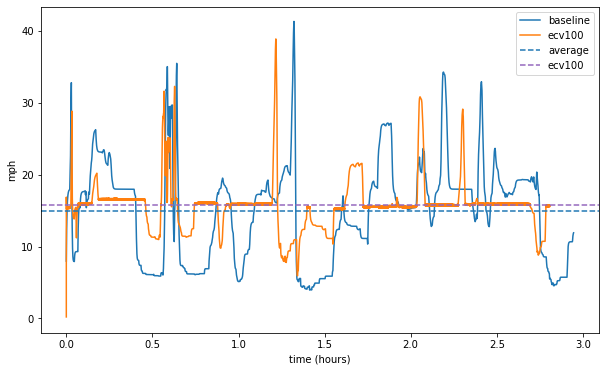

In [32]:
fig, ax = plt.subplots(figsize=[10,6])
ax.plot(baseline['hours'],baseline['mph'], label='baseline')
#ax.plot(ecv25['hours'],ecv25['mph'], label='ecv25')
#ax.plot(ecv50['hours'],ecv50['mph'], label='ecv50')
#ax.plot(ecv75['hours'],ecv75['mph'], label='ecv75')
ax.plot(ecv100['hours'],ecv100['mph'], label='ecv100')
ax.set_ylim(-2,)
ax.set_ylabel('mph'); ax.set_xlabel('time (hours)')
ax.axhline(baseline['mph'].mean(), c='C0', ls='--', label='average')
#ax.axhline(ecv25['mph'].mean(), c='C1', ls='--', label='ecv25')
#ax.axhline(ecv50['mph'].mean(), c='C2', ls='--', label='ecv50')
#ax.axhline(ecv75['mph'].mean(), c='C3', ls='--', label='ecv75')
ax.axhline(ecv100['mph'].mean(), c='C4', ls='--', label='ecv100')
ax.legend();

In [33]:
ecv100

,pa,pr,pd,pc,vel,dist,slope,timestep,pt,mph,hours,energy
0,-0.328330,0.338232,0.000253,0.000000,0.093088,0.000000,0.00000,0.2,0.010155,0.208231,0.000056,5.641403e-07
1,329.494518,0.314726,0.000204,0.000000,7.544899,0.018618,0.00000,0.2,329.809448,16.877456,0.000111,1.832331e-02
2,-139.852659,35.696765,108.481234,0.000000,7.505876,1.527597,0.00000,0.2,4.325340,16.790163,0.000167,1.856361e-02
3,-138.003292,35.464751,106.806684,0.000000,7.467168,3.028772,0.00000,0.2,4.268143,16.703577,0.000222,1.880073e-02
4,-136.185870,35.235005,105.162800,0.000000,7.428772,4.522206,0.00000,0.2,4.211934,16.617689,0.000278,1.903472e-02
...,...,...,...,...,...,...,...,...,...,...,...,...
50509,-251.902704,32.708205,88.013085,138.972220,6.961585,71058.833873,0.02056,0.2,7.790805,15.572620,2.806111,4.166255e+02
50510,82.478929,32.270762,85.215523,137.483892,6.986527,71060.226190,0.02056,0.2,337.449105,15.628415,2.806167,4.166442e+02
50511,80.969189,32.415367,86.134761,137.976481,7.010926,71061.623496,0.02056,0.2,337.495798,15.682993,2.806222,4.166630e+02
50512,79.486031,32.556986,87.040325,138.458327,7.034794,71063.025681,0.02056,0.2,337.541669,15.736385,2.806278,4.166817e+02


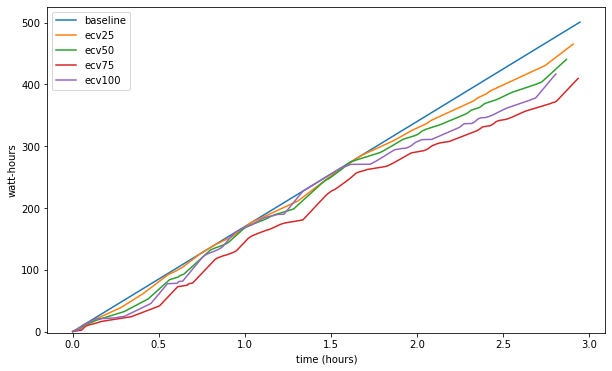

In [31]:
fig, ax = plt.subplots(figsize=[10,6])
ax.plot(baseline['hours'],baseline['energy'], label='baseline')
ax.plot(ecv25['hours'],ecv25['energy'], label='ecv25')
ax.plot(ecv50['hours'],ecv50['energy'], label='ecv50')
ax.plot(ecv75['hours'],ecv75['energy'], label='ecv75')
ax.plot(ecv100['hours'],ecv100['energy'], label='ecv100')
ax.set_ylim(-2,)
ax.set_ylabel('watt-hours'); ax.set_xlabel('time (hours)')
ax.legend();